In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import spacy
import string
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sklearn.metrics import silhouette_score
from sklearn.metrics import jaccard_score
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import hdbscan
from gensim.models import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
from gensim.corpora.dictionary import Dictionary
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from gensim.corpora import Dictionary
from transformers import BigBirdTokenizer, BigBirdModel, AutoModel, AutoTokenizer, AutoModelForPreTraining, AutoModelForMaskedLM, ReformerModel, ReformerTokenizer
import torch
from sklearn.decomposition import PCA, TruncatedSVD
from umap import UMAP
from bertopic.representation import KeyBERTInspired
from bertopic.representation import PartOfSpeech
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import ZeroShotClassification
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from sklearn.model_selection import ParameterGrid
import optuna



In [4]:
ds = pd.read_csv('student_loan_data.csv')
print(ds.shape)
ds.head()

(8185, 19)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Processed Complaint
0,2023-12-07,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Problem with customer service,In took 1 quarter at XXXX XXXX. In that quarte...,Company believes it acted appropriately as aut...,MOHELA,OH,457XX,NaN,Consent provided,Web,2023-12-07,Closed with explanation,Yes,NaN,7958117,took quarter xxxx xxxx. quarter subsidized loa...
1,2023-12-29,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,My student loan provider is currently Nelnet. ...,NaN,"Nelnet, Inc.",IA,50265,NaN,Consent provided,Web,2023-12-29,Closed with explanation,Yes,NaN,8080675,student loan provider currently nelnet. making...
2,2023-11-13,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Received bad information about your loan,on XX/XX/25 I went to student aid.gov and appl...,NaN,"Maximus Federal Services, Inc.",CA,955XX,NaN,Consent provided,Web,2023-11-13,Closed with explanation,Yes,NaN,7844168,xx/xx/ went student aid.gov applied save progr...
3,2023-11-13,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Co-signer,In response to claim number XXXX Nelnet employ...,NaN,"Nelnet, Inc.",TN,37115,NaN,Consent provided,Web,2023-11-13,Closed with explanation,Yes,NaN,7844744,response claim number xxxx nelnet employee ( x...
4,2023-10-17,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Problem with customer service,I am an authorized payor on my son 's Nelnet a...,NaN,"Nelnet, Inc.",NC,284XX,NaN,Consent provided,Web,2023-10-17,Closed with explanation,Yes,NaN,7712911,authorized payor son 's nelnet account. signin...


In [5]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

ds["Processed Complaint"] = ds["Processed Complaint"].apply(lambda text: lemmatize_words(text))
ds.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Processed Complaint
0,2023-12-07,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Problem with customer service,In took 1 quarter at XXXX XXXX. In that quarte...,Company believes it acted appropriately as aut...,MOHELA,OH,457XX,NaN,Consent provided,Web,2023-12-07,Closed with explanation,Yes,NaN,7958117,take quarter xxxx xxxx. quarter subsidize loan...
1,2023-12-29,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,My student loan provider is currently Nelnet. ...,NaN,"Nelnet, Inc.",IA,50265,NaN,Consent provided,Web,2023-12-29,Closed with explanation,Yes,NaN,8080675,student loan provider currently nelnet. make p...
2,2023-11-13,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Received bad information about your loan,on XX/XX/25 I went to student aid.gov and appl...,NaN,"Maximus Federal Services, Inc.",CA,955XX,NaN,Consent provided,Web,2023-11-13,Closed with explanation,Yes,NaN,7844168,xx/xx/ go student aid.gov apply save program s...
3,2023-11-13,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Co-signer,In response to claim number XXXX Nelnet employ...,NaN,"Nelnet, Inc.",TN,37115,NaN,Consent provided,Web,2023-11-13,Closed with explanation,Yes,NaN,7844744,response claim number xxxx nelnet employee ( x...
4,2023-10-17,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Problem with customer service,I am an authorized payor on my son 's Nelnet a...,NaN,"Nelnet, Inc.",NC,284XX,NaN,Consent provided,Web,2023-10-17,Closed with explanation,Yes,NaN,7712911,authorize payor son 's nelnet account. sign po...


In [8]:
pd.options.mode.chained_assignment = None

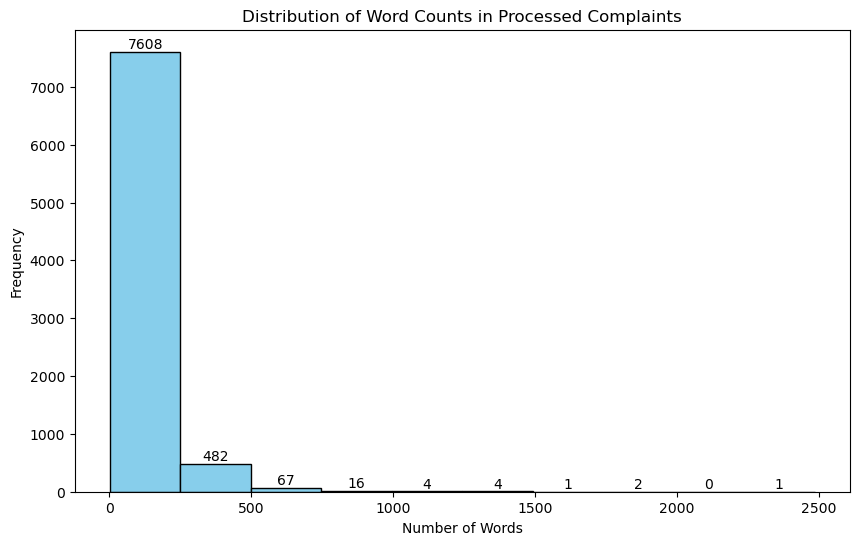

In [9]:
# Calculate the number of words in each complaint
ds['Word Count'] = ds['Processed Complaint'].apply(lambda x: len(x.split()))

# Plot histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(ds['Word Count'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Processed Complaints')

# Adding frequency labels on top of each bar
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, 
             n[i], 
             int(n[i]), 
             ha='center', 
             va='bottom')

plt.show()


In [10]:
# Load and preprocess your dataset
documents = ds['Processed Complaint'].tolist()
print(len(documents))

8185


In [11]:
# Function to calculate a basic topic diversity score
def calculate_topic_diversity(topic_model):
    unique_words = set()
    total_words = 0
    for topic in topic_model.get_topics().values():
        words = [word for word, _ in topic]  # Extract top words
        unique_words.update(words)
        total_words += len(words)
    diversity_score = len(unique_words) / total_words
    return diversity_score
def sigmoid(x):
    """
    Sigmoid function for standardizing values to (0, 1).
    """
    return 1 / (1 + np.exp(-1.0456*(x+5.60)))

def calculate_and_average_coherence_scores(topic_model, texts, dictionary):
    """
    Calculate C_v, C_umass, and C_npmi coherence scores for a BERTopic model,
    standardize them to [0, 1], and return the average standardized score.
    
    Parameters:
        topic_model: BERTopic model instance
        texts: List of preprocessed texts (list of tokenized words per document)
        dictionary: Gensim dictionary created from the texts
        
    Returns:
        Average standardized coherence score
    """
    # Extract topics from BERTopic
    topics = [[word for word, _ in topic] for topic in topic_model.get_topics().values()]

    # Define coherence metrics
    metrics = {
        "c_v": {"min": 0, "max": 1},  # C_v naturally falls in [0, 1]
        "u_mass": "sigmoid",          # Use sigmoid for C_umass
        "c_npmi": {"min": -1, "max": 1},  # C_npmi falls in [-1, 1]
    }

    # Calculate coherence scores
    coherence_scores = {}
    for metric, bounds in metrics.items():
        coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence=metric)
        score = coherence_model.get_coherence()

        if metric == "u_mass":
            # Use sigmoid for standardization of C_umass
            standardized_score = sigmoid(score)  
        else:
            # Standardize using min-max scaling
            standardized_score = (score - bounds["min"]) / (bounds["max"] - bounds["min"])
            standardized_score = max(0, min(1, standardized_score))  # Clip to [0, 1]

        coherence_scores[metric] = standardized_score

    # Average of standardized coherence scores
    average_standardized_score = np.mean(list(coherence_scores.values()))

    return average_standardized_score
# Function to calculate a Cosine Similarity
def calculate_topic_representativeness(topic_embeddings, document_embeddings):
    """
    Calculate Topic Representativeness using Cosine Similarity.

    Parameters:
        topic_embeddings: 2D array (n_topics, embedding_dim) of topic embeddings.
        document_embeddings: 2D array (n_documents, embedding_dim) of document embeddings.

    Returns:
        Standardized cosine similarity score in [0, 1].
    """
    # Compute cosine similarity between topic and document embeddings
    similarities = cosine_similarity(topic_embeddings, document_embeddings)
    
    # Take the mean of maximum similarity for each document
    average_similarity = np.mean(np.max(similarities, axis=0))
    
    # Standardize cosine similarity from [-1, 1] to [0, 1]
    standardized_similarity = (average_similarity + 1) / 2
    return standardized_similarity

# Function to calculate Silhouette Score
def calculate_silhouette_score(document_embeddings, topic_labels):
    """
    Calculate Silhouette Score and standardize it.

    Parameters:
        document_embeddings: 2D array of document embeddings.
        topic_labels: 1D array of assigned topic labels for documents.

    Returns:
        Standardized silhouette score in [0, 1].
    """
    score = silhouette_score(document_embeddings, topic_labels)
    # Standardize silhouette score from [-1, 1] to [0, 1]
    standardized_score = (score + 1) / 2
    return standardized_score
    





In [29]:
# Define custom stop words
custom_stop_words = ["xxxx", "xx","x","xxxxx", "xxxxxxxx", "xxxxxxxxxxxx"]
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)

# Define objective function for Bayesian optimization
def objective(trial):
    # Sample hyperparameters from the search space
    umap_n_neighbors = trial.suggest_int("umap_n_neighbors", 5,30)
    umap_min_dist = trial.suggest_float("umap_min_dist", 0.1, 0.99)
    umap_n_components = trial.suggest_int("umap_n_components", 2,15)
    umap_metric = trial.suggest_categorical(
        "umap_metric",
        ["euclidean", "manhattan", "chebyshev", "cosine", "correlation"],
    )
    hdbscan_min_cluster_size = trial.suggest_int("hdbscan_min_cluster_size", 5, 30)
    hdbscan_min_samples = trial.suggest_int("hdbscan_min_samples", 5,20)
    hdbscan_metric = trial.suggest_categorical(
        "hdbscan_metric",
        ["euclidean", "manhattan", "chebyshev","canberra","braycurtis"],
    )
    keybert_nr_repr_docs = trial.suggest_int("keybert_nr_repr_docs", 1, 10)
    keybert_top_n_words = trial.suggest_int("keybert_top_n_words", 5, 10)

    # Define models with current hyperparameters
    umap_model = UMAP(
        n_neighbors=umap_n_neighbors,
        min_dist=umap_min_dist,
        n_components=umap_n_components,
        metric=umap_metric,
        random_state=42,
    )
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=hdbscan_min_cluster_size, min_samples=hdbscan_min_samples,metric=hdbscan_metric, prediction_data=True
    )
    representation_model = KeyBERTInspired(
        nr_repr_docs=keybert_nr_repr_docs, top_n_words=keybert_top_n_words
    )

    # Initialize BERTopic
    topic_model = BERTopic(
        embedding_model="distilbert-base-nli-mean-tokens",
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model,
    )

    # Fit the model
    topics, probs = topic_model.fit_transform(documents)
    topic_info = topic_model.get_topic_info()
    topic_info_df = pd.DataFrame(topic_info)  # Convert topic_info to DataFrame
    
    # Restrict models generating only one topic
    unique_topics = set(topics)
    if len(unique_topics) <= 1 or topic_info_df.loc[topic_info_df["Topic"] == -1, "Count"].sum() > len(documents) * 0.055:
        return float("inf")  # Invalid configuration

    # Calculate evaluation metrics
    tokenized_documents = [doc.split() for doc in documents]
    dictionary = Dictionary(tokenized_documents)
    coherence_score = calculate_and_average_coherence_scores(topic_model, tokenized_documents, dictionary)
    sentence_transformer_model = topic_model.embedding_model
    topic_embeddings = topic_model.topic_embeddings_
    document_embeddings = sentence_transformer_model.embedding_model.encode(documents, show_progress_bar=True)
    # Use consistent `documents` for `get_document_info`
    document_info = topic_model.get_document_info(documents)
    topic_labels = document_info["Topic"].values

    diversity_score = calculate_topic_diversity(topic_model)
    representativeness_score = calculate_topic_representativeness(topic_embeddings, document_embeddings)
    silhouette = calculate_silhouette_score(document_embeddings, topic_labels)

    # Combine metrics into a single score
    final_score = -np.mean([coherence_score, diversity_score, representativeness_score, silhouette])
    return final_score

# Perform Bayesian Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)

# Best parameters and model
best_params = study.best_params
print("Best Parameters:", best_params)
print("Best Score:", study.best_value)

# Save the best model
# Reinitialize with the best parameters if needed and save

[I 2024-11-30 20:59:47,296] A new study created in memory with name: no-name-02ee8f73-c76c-45cd-8a2a-f135e95a5740
[I 2024-11-30 21:00:19,372] Trial 0 finished with value: inf and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.32736361487919724, 'umap_n_components': 8, 'umap_metric': 'correlation', 'hdbscan_min_cluster_size': 18, 'hdbscan_min_samples': 7, 'hdbscan_metric': 'euclidean', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 8}. Best is trial 0 with value: inf.
[I 2024-11-30 21:00:51,146] Trial 1 finished with value: inf and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.5390507384836158, 'umap_n_components': 8, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 5, 'hdbscan_min_samples': 18, 'hdbscan_metric': 'chebyshev', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 0 with value: inf.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:02:19,650] Trial 2 finished with value: -0.6693765706148563 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.41743836248300387, 'umap_n_components': 11, 'umap_metric': 'manhattan', 'hdbscan_min_cluster_size': 19, 'hdbscan_min_samples': 6, 'hdbscan_metric': 'manhattan', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 9}. Best is trial 2 with value: -0.6693765706148563.
[I 2024-11-30 21:03:04,216] Trial 3 finished with value: inf and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.14263152307037044, 'umap_n_components': 8, 'umap_metric': 'chebyshev', 'hdbscan_min_cluster_size': 11, 'hdbscan_min_samples': 6, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 2 with value: -0.6693765706148563.
[I 2024-11-30 21:03:48,190] Trial 4 finished with value: inf and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.3125074916421488, 'umap_n_components': 6, 'umap_metric': 'correlation', 'hdbscan_min_cluster_si

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:06:02,413] Trial 6 finished with value: -0.6444679217135472 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.5825436336066253, 'umap_n_components': 10, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 16, 'hdbscan_min_samples': 16, 'hdbscan_metric': 'braycurtis', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 2 with value: -0.6693765706148563.
[I 2024-11-30 21:06:45,726] Trial 7 finished with value: inf and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.4243193190498986, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'hdbscan_min_cluster_size': 21, 'hdbscan_min_samples': 9, 'hdbscan_metric': 'chebyshev', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 10}. Best is trial 2 with value: -0.6693765706148563.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:08:14,811] Trial 8 finished with value: -0.6387072104572039 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.4224099244564476, 'umap_n_components': 12, 'umap_metric': 'correlation', 'hdbscan_min_cluster_size': 15, 'hdbscan_min_samples': 10, 'hdbscan_metric': 'manhattan', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 9}. Best is trial 2 with value: -0.6693765706148563.
[I 2024-11-30 21:08:55,441] Trial 9 finished with value: inf and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.9633073358280673, 'umap_n_components': 4, 'umap_metric': 'correlation', 'hdbscan_min_cluster_size': 15, 'hdbscan_min_samples': 8, 'hdbscan_metric': 'braycurtis', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 10}. Best is trial 2 with value: -0.6693765706148563.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:10:17,327] Trial 10 finished with value: -0.6708263865151654 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.1205102918912298, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'hdbscan_min_cluster_size': 27, 'hdbscan_min_samples': 12, 'hdbscan_metric': 'manhattan', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 5}. Best is trial 10 with value: -0.6708263865151654.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:11:38,946] Trial 11 finished with value: -0.683733189625182 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.1330341953474075, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'hdbscan_min_cluster_size': 30, 'hdbscan_min_samples': 14, 'hdbscan_metric': 'manhattan', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 5}. Best is trial 11 with value: -0.683733189625182.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:13:00,023] Trial 12 finished with value: -0.6651870753345468 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.10694124481869606, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'hdbscan_min_cluster_size': 30, 'hdbscan_min_samples': 13, 'hdbscan_metric': 'manhattan', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 5}. Best is trial 11 with value: -0.683733189625182.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:14:21,386] Trial 13 finished with value: -0.6425037803297986 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.20919143673086105, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'hdbscan_min_cluster_size': 25, 'hdbscan_min_samples': 13, 'hdbscan_metric': 'manhattan', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 5}. Best is trial 11 with value: -0.683733189625182.
[I 2024-11-30 21:15:02,153] Trial 14 finished with value: inf and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.25412166115105506, 'umap_n_components': 13, 'umap_metric': 'manhattan', 'hdbscan_min_cluster_size': 30, 'hdbscan_min_samples': 11, 'hdbscan_metric': 'manhattan', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 6}. Best is trial 11 with value: -0.683733189625182.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:16:25,720] Trial 15 finished with value: -0.6692277675579115 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.10731115752147909, 'umap_n_components': 13, 'umap_metric': 'manhattan', 'hdbscan_min_cluster_size': 24, 'hdbscan_min_samples': 15, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 2, 'keybert_top_n_words': 6}. Best is trial 11 with value: -0.683733189625182.
[I 2024-11-30 21:17:08,108] Trial 16 finished with value: inf and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.8035697331788652, 'umap_n_components': 15, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 26, 'hdbscan_min_samples': 15, 'hdbscan_metric': 'manhattan', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 5}. Best is trial 11 with value: -0.683733189625182.
[I 2024-11-30 21:17:46,936] Trial 17 finished with value: inf and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.2177672477931959, 'umap_n_components': 13, 'umap_metric': 'manhattan', 'hdbscan_min_cluster_siz

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:19:15,427] Trial 18 finished with value: -0.6740818867300407 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.5675863795499172, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'hdbscan_min_cluster_size': 28, 'hdbscan_min_samples': 12, 'hdbscan_metric': 'manhattan', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 5}. Best is trial 11 with value: -0.683733189625182.
[I 2024-11-30 21:19:57,639] Trial 19 finished with value: inf and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.6687534704257042, 'umap_n_components': 11, 'umap_metric': 'manhattan', 'hdbscan_min_cluster_size': 29, 'hdbscan_min_samples': 14, 'hdbscan_metric': 'chebyshev', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 11 with value: -0.683733189625182.
[I 2024-11-30 21:20:39,118] Trial 20 finished with value: inf and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.5276996313947975, 'umap_n_components': 6, 'umap_metric': 'cosine', 'hdbscan_min_cluster_si

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:24:01,041] Trial 24 finished with value: -0.7159074271937671 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.18080361327534247, 'umap_n_components': 2, 'umap_metric': 'manhattan', 'hdbscan_min_cluster_size': 30, 'hdbscan_min_samples': 14, 'hdbscan_metric': 'manhattan', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 6}. Best is trial 24 with value: -0.7159074271937671.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:25:23,505] Trial 25 finished with value: -0.7368298468274422 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.8272005515156714, 'umap_n_components': 2, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 29, 'hdbscan_min_samples': 14, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 6}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:26:46,530] Trial 26 finished with value: -0.7363546530227901 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.9148232789694264, 'umap_n_components': 2, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 30, 'hdbscan_min_samples': 14, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 2, 'keybert_top_n_words': 6}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:28:08,730] Trial 27 finished with value: -0.6731170213481914 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.9516640036078171, 'umap_n_components': 2, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 10, 'hdbscan_min_samples': 16, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 2, 'keybert_top_n_words': 7}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:29:34,463] Trial 28 finished with value: -0.6462139856963409 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.8815697827776282, 'umap_n_components': 2, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 25, 'hdbscan_min_samples': 14, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 6}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:30:59,162] Trial 29 finished with value: -0.7098828297224135 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.8343491273312093, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 19, 'hdbscan_min_samples': 20, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:32:26,937] Trial 30 finished with value: -0.6432636354954612 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.7193810961361203, 'umap_n_components': 6, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 21, 'hdbscan_min_samples': 15, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 2, 'keybert_top_n_words': 6}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:33:52,229] Trial 31 finished with value: -0.6641431372964401 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.8615559717093448, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 19, 'hdbscan_min_samples': 19, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:34:52,040] Trial 32 finished with value: -0.7211785163821278 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.8260676929520032, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 11, 'hdbscan_min_samples': 17, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:35:55,582] Trial 33 finished with value: -0.6959603402256801 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.9199877075393292, 'umap_n_components': 4, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 11, 'hdbscan_min_samples': 14, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:36:56,990] Trial 34 finished with value: -0.703035246513134 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.7770709515058005, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 8, 'hdbscan_min_samples': 17, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 6}. Best is trial 25 with value: -0.7368298468274422.
[I 2024-11-30 21:37:27,150] Trial 35 finished with value: inf and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.9073894623861799, 'umap_n_components': 5, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 13, 'hdbscan_min_samples': 17, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 6}. Best is trial 25 with value: -0.7368298468274422.
[I 2024-11-30 21:37:53,866] Trial 36 finished with value: inf and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.9862463751498922, 'umap_n_components': 2, 'umap_metric': 'chebyshev', 'hdbscan_min_cluster_size

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:38:57,467] Trial 37 finished with value: -0.6132835017073119 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.7447348324253197, 'umap_n_components': 7, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 7, 'hdbscan_min_samples': 18, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.
[I 2024-11-30 21:39:26,206] Trial 38 finished with value: inf and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.6811833912910271, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 17, 'hdbscan_min_samples': 15, 'hdbscan_metric': 'chebyshev', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:40:26,160] Trial 39 finished with value: -0.6677382496358905 and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.8304833898692637, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'hdbscan_min_cluster_size': 13, 'hdbscan_min_samples': 13, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 9}. Best is trial 25 with value: -0.7368298468274422.
[I 2024-11-30 21:40:54,485] Trial 40 finished with value: inf and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.3851272207963512, 'umap_n_components': 2, 'umap_metric': 'correlation', 'hdbscan_min_cluster_size': 25, 'hdbscan_min_samples': 10, 'hdbscan_metric': 'braycurtis', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 6}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:41:52,796] Trial 41 finished with value: -0.7204720122480335 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.8303624676721805, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 18, 'hdbscan_min_samples': 20, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:42:53,000] Trial 42 finished with value: -0.6668488704207033 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.7782609030202021, 'umap_n_components': 4, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 5, 'hdbscan_min_samples': 19, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:43:51,230] Trial 43 finished with value: -0.7190284487040032 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.9214477356120387, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 13, 'hdbscan_min_samples': 19, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:44:51,044] Trial 44 finished with value: -0.7296805048520623 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.9158475465000627, 'umap_n_components': 5, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 13, 'hdbscan_min_samples': 19, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.
[I 2024-11-30 21:45:19,534] Trial 45 finished with value: inf and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.8805384854322461, 'umap_n_components': 5, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 11, 'hdbscan_min_samples': 18, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:46:20,797] Trial 46 finished with value: -0.7076050246692258 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.8450673899189467, 'umap_n_components': 4, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 8, 'hdbscan_min_samples': 20, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 9}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:47:23,166] Trial 47 finished with value: -0.6672868446414513 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.9311393536988325, 'umap_n_components': 7, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 15, 'hdbscan_min_samples': 5, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.
[I 2024-11-30 21:47:51,826] Trial 48 finished with value: inf and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.9828533982467702, 'umap_n_components': 5, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 14, 'hdbscan_min_samples': 19, 'hdbscan_metric': 'braycurtis', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:48:50,561] Trial 49 finished with value: -0.6656406386549195 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.7841827995506115, 'umap_n_components': 9, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 17, 'hdbscan_min_samples': 17, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 9}. Best is trial 25 with value: -0.7368298468274422.
[I 2024-11-30 21:49:20,821] Trial 50 finished with value: inf and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.7339958960702915, 'umap_n_components': 4, 'umap_metric': 'correlation', 'hdbscan_min_cluster_size': 9, 'hdbscan_min_samples': 18, 'hdbscan_metric': 'euclidean', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 7}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:50:18,713] Trial 51 finished with value: -0.716679792122682 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.8962938052898551, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 13, 'hdbscan_min_samples': 19, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:51:17,175] Trial 52 finished with value: -0.696829942404948 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.9428024735184817, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 12, 'hdbscan_min_samples': 20, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:52:15,220] Trial 53 finished with value: -0.7054141802095399 and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.8658781969072049, 'umap_n_components': 2, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 16, 'hdbscan_min_samples': 18, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.
[I 2024-11-30 21:52:43,344] Trial 54 finished with value: inf and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.8130508843890837, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 10, 'hdbscan_min_samples': 19, 'hdbscan_metric': 'chebyshev', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 9}. Best is trial 25 with value: -0.7368298468274422.
[I 2024-11-30 21:53:08,817] Trial 55 finished with value: inf and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.9225992229317238, 'umap_n_components': 2, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_s

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:54:34,260] Trial 57 finished with value: -0.7165150649107738 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.8080347672320841, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 20, 'hdbscan_min_samples': 19, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 25 with value: -0.7368298468274422.
[I 2024-11-30 21:55:04,579] Trial 58 finished with value: inf and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.6419079162318109, 'umap_n_components': 6, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 18, 'hdbscan_min_samples': 18, 'hdbscan_metric': 'braycurtis', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:56:00,333] Trial 59 finished with value: -0.6511907327445539 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.9578415380825287, 'umap_n_components': 2, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 7, 'hdbscan_min_samples': 8, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 6}. Best is trial 25 with value: -0.7368298468274422.
[I 2024-11-30 21:56:32,011] Trial 60 finished with value: inf and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.757883384561418, 'umap_n_components': 5, 'umap_metric': 'correlation', 'hdbscan_min_cluster_size': 29, 'hdbscan_min_samples': 17, 'hdbscan_metric': 'euclidean', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 9}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:57:29,531] Trial 61 finished with value: -0.6975973894178813 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.899432498770195, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 13, 'hdbscan_min_samples': 19, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:58:27,932] Trial 62 finished with value: -0.6885196400115758 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.8735162734551664, 'umap_n_components': 4, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 12, 'hdbscan_min_samples': 20, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 21:59:25,936] Trial 63 finished with value: -0.6851735232734706 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.9015776288623925, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 14, 'hdbscan_min_samples': 19, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:00:24,717] Trial 64 finished with value: -0.632978501086975 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.8466857800236621, 'umap_n_components': 2, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 15, 'hdbscan_min_samples': 13, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:01:23,858] Trial 65 finished with value: -0.6950734015445812 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.81308130966611, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 16, 'hdbscan_min_samples': 18, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.
[I 2024-11-30 22:01:51,634] Trial 66 finished with value: inf and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.9550921699850301, 'umap_n_components': 4, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 9, 'hdbscan_min_samples': 20, 'hdbscan_metric': 'chebyshev', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 7}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:02:52,594] Trial 67 finished with value: -0.6436705320186663 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.8940126693155974, 'umap_n_components': 10, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 11, 'hdbscan_min_samples': 15, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:03:50,215] Trial 68 finished with value: -0.68330850917243 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.9891461789263268, 'umap_n_components': 2, 'umap_metric': 'euclidean', 'hdbscan_min_cluster_size': 23, 'hdbscan_min_samples': 16, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 25 with value: -0.7368298468274422.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:04:46,826] Trial 69 finished with value: -0.755678108505579 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.8476855423692068, 'umap_n_components': 3, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 10, 'hdbscan_min_samples': 19, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:05:43,672] Trial 70 finished with value: -0.7401237932639988 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.7117590541071246, 'umap_n_components': 2, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 10, 'hdbscan_min_samples': 11, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:06:40,408] Trial 71 finished with value: -0.7412455994174821 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.8380918022091174, 'umap_n_components': 2, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 9, 'hdbscan_min_samples': 11, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:07:36,729] Trial 72 finished with value: -0.5944545637524592 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.7891510002019401, 'umap_n_components': 2, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 6, 'hdbscan_min_samples': 11, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:08:32,895] Trial 73 finished with value: -0.697834281836058 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.7090139266139469, 'umap_n_components': 2, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 10, 'hdbscan_min_samples': 10, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:09:29,092] Trial 74 finished with value: -0.6329550725492307 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.7551414561780277, 'umap_n_components': 2, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 9, 'hdbscan_min_samples': 9, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.
[I 2024-11-30 22:09:55,662] Trial 75 finished with value: inf and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.8288702075040882, 'umap_n_components': 3, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 10, 'hdbscan_min_samples': 11, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:10:51,937] Trial 76 finished with value: -0.7329459247861406 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.8541438763926705, 'umap_n_components': 4, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 8, 'hdbscan_min_samples': 12, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.
[I 2024-11-30 22:11:17,436] Trial 77 finished with value: inf and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.8561355941967752, 'umap_n_components': 4, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 8, 'hdbscan_min_samples': 12, 'hdbscan_metric': 'euclidean', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:12:13,191] Trial 78 finished with value: -0.7345478439625822 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.7654254010040586, 'umap_n_components': 2, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 7, 'hdbscan_min_samples': 13, 'hdbscan_metric': 'braycurtis', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.
[I 2024-11-30 22:12:39,210] Trial 79 finished with value: inf and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.6229242354910434, 'umap_n_components': 2, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 6, 'hdbscan_min_samples': 13, 'hdbscan_metric': 'braycurtis', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:13:34,185] Trial 80 finished with value: -0.7173231945568788 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.4981465583820621, 'umap_n_components': 2, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 7, 'hdbscan_min_samples': 10, 'hdbscan_metric': 'braycurtis', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:14:30,834] Trial 81 finished with value: -0.7238587707397734 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.7686683775094906, 'umap_n_components': 2, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 9, 'hdbscan_min_samples': 12, 'hdbscan_metric': 'braycurtis', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.
[I 2024-11-30 22:14:57,358] Trial 82 finished with value: inf and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.7630375784005718, 'umap_n_components': 2, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 8, 'hdbscan_min_samples': 12, 'hdbscan_metric': 'braycurtis', 'keybert_nr_repr_docs': 2, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.
[I 2024-11-30 22:15:22,615] Trial 83 finished with value: inf and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.7134510816460184, 'umap_n_components': 2, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 6, '

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:16:19,113] Trial 84 finished with value: -0.7356104865800188 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.8560629842332355, 'umap_n_components': 4, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 9, 'hdbscan_min_samples': 13, 'hdbscan_metric': 'braycurtis', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.
[I 2024-11-30 22:16:45,417] Trial 85 finished with value: inf and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.8713054898897982, 'umap_n_components': 4, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 28, 'hdbscan_min_samples': 14, 'hdbscan_metric': 'braycurtis', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.
[I 2024-11-30 22:17:10,931] Trial 86 finished with value: inf and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.9316931604192294, 'umap_n_components': 5, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 5, 

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:19:27,902] Trial 90 finished with value: -0.6525707142636658 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.8460230560534873, 'umap_n_components': 6, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 9, 'hdbscan_min_samples': 11, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.
[I 2024-11-30 22:19:54,194] Trial 91 finished with value: inf and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.7715966385126737, 'umap_n_components': 2, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 9, 'hdbscan_min_samples': 12, 'hdbscan_metric': 'braycurtis', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 10}. Best is trial 69 with value: -0.755678108505579.
[I 2024-11-30 22:20:21,021] Trial 92 finished with value: inf and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.8003830417466535, 'umap_n_components': 3, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 11, 'h

Best Parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.8476855423692068, 'umap_n_components': 3, 'umap_metric': 'cosine', 'hdbscan_min_cluster_size': 10, 'hdbscan_min_samples': 19, 'hdbscan_metric': 'canberra', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 10}
Best Score: -0.755678108505579


In [30]:
# Define custom stop words
custom_stop_words = ["xxxx", "xx","x","xxxxx", "xxxxxxxx", "xxxxxxxxxxxx"]
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)

# Define objective function for Bayesian optimization
def objective(trial):
    # Sample hyperparameters from the search space
    umap_n_neighbors = trial.suggest_int("umap_n_neighbors", 5,30)
    umap_min_dist = trial.suggest_float("umap_min_dist", 0.1, 0.99)
    umap_n_components = trial.suggest_int("umap_n_components", 2,15)
    umap_metric = trial.suggest_categorical(
        "umap_metric",
        ["euclidean", "manhattan", "chebyshev", "cosine", "correlation"],
    )
    Spectral_n_cluster = trial.suggest_int("Spectral_n_cluster", 5, 50)
    Spectral_eigen_solver = trial.suggest_categorical("Spectral_eigen_solver", ["arpack","lobpcg","amg"])
    Spectral_affinity = trial.suggest_categorical("Spectral_affinity", ["nearest_neighbors","rbf"])
    Spectral_assign_labels = trial.suggest_categorical(
        "Spectral_assign_labels",
        ["kmeans", "discretize", "cluster_qr"],
    )
    keybert_nr_repr_docs = trial.suggest_int("keybert_nr_repr_docs", 1, 10)
    keybert_top_n_words = trial.suggest_int("keybert_top_n_words", 5, 10)

    # Define models with current hyperparameters
    umap_model = UMAP(
        n_neighbors=umap_n_neighbors,
        min_dist=umap_min_dist,
        n_components=umap_n_components,
        metric=umap_metric,
        random_state=42,
    )
    Spectral_model = SpectralClustering(n_clusters=Spectral_n_cluster,eigen_solver=Spectral_eigen_solver,affinity=Spectral_affinity,assign_labels=Spectral_assign_labels)
    representation_model = KeyBERTInspired(
        nr_repr_docs=keybert_nr_repr_docs, top_n_words=keybert_top_n_words
    )

    # Initialize BERTopic
    topic_model = BERTopic(
        embedding_model=AutoModel.from_pretrained("albert-base-v1"),
        umap_model=umap_model,
        hdbscan_model=Spectral_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model,
    )

    # Fit the model
    topics, probs = topic_model.fit_transform(documents)
    topic_info = topic_model.get_topic_info()
    topic_info_df = pd.DataFrame(topic_info)  # Convert topic_info to DataFrame
    
    # Restrict models generating only one topic
    unique_topics = set(topics)
    if (len(unique_topics) <= 1 or (topic_info_df["Topic"] == -1).any()):
        return float("inf")  # Invalid configuration

    # Calculate evaluation metrics
    tokenized_documents = [doc.split() for doc in documents]
    dictionary = Dictionary(tokenized_documents)
    coherence_score = calculate_and_average_coherence_scores(topic_model, tokenized_documents, dictionary)
    sentence_transformer_model = topic_model.embedding_model
    topic_embeddings = topic_model.topic_embeddings_
    document_embeddings = sentence_transformer_model.embedding_model.encode(documents, show_progress_bar=True)
    # Use consistent `documents` for `get_document_info`
    document_info = topic_model.get_document_info(documents)
    topic_labels = document_info["Topic"].values

    diversity_score = calculate_topic_diversity(topic_model)
    representativeness_score = calculate_topic_representativeness(topic_embeddings, document_embeddings)
    silhouette = calculate_silhouette_score(document_embeddings, topic_labels)

    # Combine metrics into a single score
    final_score = -np.mean([coherence_score, diversity_score, representativeness_score, silhouette])
    return final_score

# Perform Bayesian Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)

# Best parameters and model
best_params = study.best_params
print("Best Parameters:", best_params)
print("Best Score:", study.best_value)

# Save the best model
# Reinitialize with the best parameters if needed and save

[I 2024-11-30 22:23:20,409] A new study created in memory with name: no-name-3a61397c-4515-478b-a47c-dcb1d635216d


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:25:01,415] Trial 0 finished with value: -0.636202857080888 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.627529626384329, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 9}. Best is trial 0 with value: -0.636202857080888.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:26:05,182] Trial 1 finished with value: -0.6029289672245193 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.2814809330288449, 'umap_n_components': 13, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 37, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 8}. Best is trial 0 with value: -0.636202857080888.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:27:11,261] Trial 2 finished with value: -0.6429990928192372 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.45961279755355505, 'umap_n_components': 10, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 6}. Best is trial 2 with value: -0.6429990928192372.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:28:13,417] Trial 3 finished with value: -0.5981985495263893 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.49775021370537864, 'umap_n_components': 2, 'umap_metric': 'cosine', 'Spectral_n_cluster': 26, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 9}. Best is trial 2 with value: -0.6429990928192372.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:29:18,890] Trial 4 finished with value: -0.5855813642917442 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.6929339607227014, 'umap_n_components': 7, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 38, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 5}. Best is trial 2 with value: -0.6429990928192372.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:30:29,481] Trial 5 finished with value: -0.5913456419646987 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.1296179429389551, 'umap_n_components': 12, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 31, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 5}. Best is trial 2 with value: -0.6429990928192372.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:31:39,790] Trial 6 finished with value: -0.5912854195631579 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.698198948573917, 'umap_n_components': 11, 'umap_metric': 'correlation', 'Spectral_n_cluster': 33, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 7}. Best is trial 2 with value: -0.6429990928192372.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:32:53,570] Trial 7 finished with value: -0.5815217113581526 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.9732966550769433, 'umap_n_components': 12, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 44, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 10}. Best is trial 2 with value: -0.6429990928192372.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:33:54,393] Trial 8 finished with value: -0.6325692313361369 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.6347667931760713, 'umap_n_components': 8, 'umap_metric': 'cosine', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 9}. Best is trial 2 with value: -0.6429990928192372.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:34:59,304] Trial 9 finished with value: -0.6346481882294028 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.6601795448034953, 'umap_n_components': 11, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 9}. Best is trial 2 with value: -0.6429990928192372.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:36:06,351] Trial 10 finished with value: -0.5993638884361494 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.34991674842272874, 'umap_n_components': 15, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 19, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 6}. Best is trial 2 with value: -0.6429990928192372.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:37:12,727] Trial 11 finished with value: -0.6159658722091917 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.47284260514885096, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 15, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 7}. Best is trial 2 with value: -0.6429990928192372.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:38:23,101] Trial 12 finished with value: -0.6658404814708636 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.930582316843898, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 12 with value: -0.6658404814708636.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:39:27,712] Trial 13 finished with value: -0.6059452785565794 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.9437323036811538, 'umap_n_components': 9, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 18, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 6}. Best is trial 12 with value: -0.6658404814708636.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:40:36,803] Trial 14 finished with value: -0.6407155730078637 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.8448722195464681, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 12 with value: -0.6658404814708636.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:41:47,713] Trial 15 finished with value: -0.6050774898371767 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.8034109856880767, 'umap_n_components': 9, 'umap_metric': 'correlation', 'Spectral_n_cluster': 14, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 6}. Best is trial 12 with value: -0.6658404814708636.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:42:53,888] Trial 16 finished with value: -0.5950188258193099 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.35109868134147754, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 24, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 7}. Best is trial 12 with value: -0.6658404814708636.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:44:01,527] Trial 17 finished with value: -0.5814580147226657 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.4332200418981723, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 49, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 5}. Best is trial 12 with value: -0.6658404814708636.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:45:07,069] Trial 18 finished with value: -0.6169741047968038 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.16451786167698718, 'umap_n_components': 10, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 13, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 12 with value: -0.6658404814708636.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:46:20,846] Trial 19 finished with value: -0.6025158868166067 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.830828356103527, 'umap_n_components': 15, 'umap_metric': 'cosine', 'Spectral_n_cluster': 22, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 6}. Best is trial 12 with value: -0.6658404814708636.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:47:28,119] Trial 20 finished with value: -0.6244608193834469 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.23312930848253763, 'umap_n_components': 5, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 5}. Best is trial 12 with value: -0.6658404814708636.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:48:36,678] Trial 21 finished with value: -0.6659508034805662 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.8674301916433704, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 21 with value: -0.6659508034805662.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:49:45,069] Trial 22 finished with value: -0.6703350506381993 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.8950871196579198, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 22 with value: -0.6703350506381993.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:50:54,461] Trial 23 finished with value: -0.6702942553479071 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.8977861641732813, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 22 with value: -0.6703350506381993.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:52:02,975] Trial 24 finished with value: -0.6052104096629355 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.7751387880025136, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 17, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 22 with value: -0.6703350506381993.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:53:09,416] Trial 25 finished with value: -0.6286913147265148 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.8897198663935207, 'umap_n_components': 3, 'umap_metric': 'correlation', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 8}. Best is trial 22 with value: -0.6703350506381993.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:54:19,197] Trial 26 finished with value: -0.6234736591932348 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.7252462276431068, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 22 with value: -0.6703350506381993.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:55:27,203] Trial 27 finished with value: -0.5988651616791905 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.5741828805819746, 'umap_n_components': 8, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 20, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 22 with value: -0.6703350506381993.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:56:31,773] Trial 28 finished with value: -0.6220807385295598 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.8927184311790303, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 13, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 22 with value: -0.6703350506381993.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:57:39,637] Trial 29 finished with value: -0.6793754388336395 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.9848775762481192, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 10}. Best is trial 29 with value: -0.6793754388336395.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:58:49,361] Trial 30 finished with value: -0.6328990870259543 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.9815974182959457, 'umap_n_components': 6, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 10}. Best is trial 29 with value: -0.6793754388336395.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 22:59:57,571] Trial 31 finished with value: -0.679987302168405 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.8778255494423196, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:01:05,523] Trial 32 finished with value: -0.6685578133157736 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.7890575758230174, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 10}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:02:13,993] Trial 33 finished with value: -0.624674031216377 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.9232801492884514, 'umap_n_components': 6, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:03:23,000] Trial 34 finished with value: -0.6291084174590538 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.7615743507652213, 'umap_n_components': 8, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:04:30,782] Trial 35 finished with value: -0.6089080844357948 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.8654886050683998, 'umap_n_components': 6, 'umap_metric': 'cosine', 'Spectral_n_cluster': 16, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:05:38,598] Trial 36 finished with value: -0.611868686177597 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.5723407103225504, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 10}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:06:48,127] Trial 37 finished with value: -0.5875058482531289 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.9652847087277726, 'umap_n_components': 7, 'umap_metric': 'correlation', 'Spectral_n_cluster': 30, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:07:52,531] Trial 38 finished with value: -0.6493860496357424 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.9886879553548023, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:09:01,335] Trial 39 finished with value: -0.5875204009387622 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.9090579737129291, 'umap_n_components': 2, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 41, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:10:12,416] Trial 40 finished with value: -0.589036648905636 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.7318667889925392, 'umap_n_components': 9, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 35, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:11:22,112] Trial 41 finished with value: -0.664067630430175 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.81317047334007, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 10}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:12:29,746] Trial 42 finished with value: -0.649885447521922 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.7905096116324385, 'umap_n_components': 8, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 10}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:13:37,744] Trial 43 finished with value: -0.6327823656863885 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.8516307496062343, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 10}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:14:45,742] Trial 44 finished with value: -0.6684290813175542 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.9277007764513806, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:15:53,671] Trial 45 finished with value: -0.6302919681027015 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.6909753353565484, 'umap_n_components': 5, 'umap_metric': 'cosine', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 10}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:17:01,083] Trial 46 finished with value: -0.6335969444250266 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.8873107023704725, 'umap_n_components': 10, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:18:12,184] Trial 47 finished with value: -0.6380868238158308 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.94248387849861, 'umap_n_components': 8, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:19:20,883] Trial 48 finished with value: -0.5927001905774318 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.74744997290822, 'umap_n_components': 6, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 15, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 10}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:20:28,558] Trial 49 finished with value: -0.6793215438692156 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.8230071122241797, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:21:34,747] Trial 50 finished with value: -0.5925463369028563 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.8332331726674852, 'umap_n_components': 4, 'umap_metric': 'correlation', 'Spectral_n_cluster': 27, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:22:43,445] Trial 51 finished with value: -0.6762534922330545 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.9556253380230563, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:23:51,487] Trial 52 finished with value: -0.64211771123161 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.9897327283381541, 'umap_n_components': 9, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:25:00,409] Trial 53 finished with value: -0.6380738934711174 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.9443350286218583, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:26:08,352] Trial 54 finished with value: -0.6558456554664395 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.8970499075228597, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:27:24,117] Trial 55 finished with value: -0.6152502738535971 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.9600590389582376, 'umap_n_components': 14, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:28:30,283] Trial 56 finished with value: -0.6300930118470223 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.8596276531782888, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:29:39,233] Trial 57 finished with value: -0.6642086180178961 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.8186704248176925, 'umap_n_components': 8, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:30:50,969] Trial 58 finished with value: -0.5946518983032478 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.6403937240943918, 'umap_n_components': 10, 'umap_metric': 'cosine', 'Spectral_n_cluster': 14, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:32:07,726] Trial 59 finished with value: -0.5775224630638653 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.9222635316068086, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 49, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:33:13,473] Trial 60 finished with value: -0.6255817896098217 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.8756439369148031, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:34:22,918] Trial 61 finished with value: -0.6379931071589625 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.8417431755537403, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:35:33,810] Trial 62 finished with value: -0.6744925409944919 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.7817601733240958, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:36:45,311] Trial 63 finished with value: -0.6319264205891734 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.9537733452276773, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 5}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:37:56,547] Trial 64 finished with value: -0.6309657707908097 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.9016992833987671, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:39:07,729] Trial 65 finished with value: -0.6529973399559023 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.6998066416442337, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:40:13,347] Trial 66 finished with value: -0.643730375852286 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.8056227389587326, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 2, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:41:24,912] Trial 67 finished with value: -0.6136569916580896 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.916663797543825, 'umap_n_components': 8, 'umap_metric': 'correlation', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 5}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:42:34,826] Trial 68 finished with value: -0.6306534475698737 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.7712841800715695, 'umap_n_components': 6, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:43:51,555] Trial 69 finished with value: -0.6255162624374163 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.8740329548440092, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 13, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:45:04,258] Trial 70 finished with value: -0.5873457203009657 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.3993155027573249, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 24, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:46:17,143] Trial 71 finished with value: -0.6726127130741089 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.8285346198598951, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:47:29,731] Trial 72 finished with value: -0.6343426014431296 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.8551662524256137, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:48:41,259] Trial 73 finished with value: -0.6446864610413066 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.9628479109460524, 'umap_n_components': 8, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:49:52,366] Trial 74 finished with value: -0.6391867055699632 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.8225263063738839, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:51:02,241] Trial 75 finished with value: -0.6741642820249206 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.9321844412582553, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:52:15,620] Trial 76 finished with value: -0.5901975603072089 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.937249621434389, 'umap_n_components': 9, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 47, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:53:26,228] Trial 77 finished with value: -0.6249368923439484 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.7882588530163088, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:54:35,977] Trial 78 finished with value: -0.6505451687457627 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.4920589751751794, 'umap_n_components': 6, 'umap_metric': 'cosine', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:55:48,911] Trial 79 finished with value: -0.5785733479256477 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.9691298830754881, 'umap_n_components': 8, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 39, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 5}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:56:55,264] Trial 80 finished with value: -0.6665214577735747 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.9114411132903848, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:58:05,494] Trial 81 finished with value: -0.6515048400141017 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.9011267301301633, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-11-30 23:59:15,106] Trial 82 finished with value: -0.641809743565542 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.8778119557578303, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:00:23,024] Trial 83 finished with value: -0.669774790210873 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.8513031156133604, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:01:31,321] Trial 84 finished with value: -0.6420300963026759 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.9327900961526621, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:02:40,993] Trial 85 finished with value: -0.6275558892392885 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.7561425823360228, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:03:49,243] Trial 86 finished with value: -0.6145167265850098 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.24587927311924807, 'umap_n_components': 5, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:04:48,268] Trial 87 finished with value: -0.6697710227956075 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.9781837494395628, 'umap_n_components': 7, 'umap_metric': 'correlation', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:06:01,235] Trial 88 finished with value: -0.5901003280781639 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.5468896577050124, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 30, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:07:08,515] Trial 89 finished with value: -0.6413754957977466 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.8340378875431628, 'umap_n_components': 8, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:08:13,604] Trial 90 finished with value: -0.6248266260651408 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.8837174827787644, 'umap_n_components': 11, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:09:21,142] Trial 91 finished with value: -0.6625561912246469 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.8478383247789864, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:10:28,773] Trial 92 finished with value: -0.6470039354888606 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.8102292370956096, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:11:36,001] Trial 93 finished with value: -0.6323687390147305 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.11029306578204712, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:12:45,234] Trial 94 finished with value: -0.6400854436667012 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.9560657148280489, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:13:55,291] Trial 95 finished with value: -0.6589142916349722 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.7243659674623949, 'umap_n_components': 6, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:15:04,523] Trial 96 finished with value: -0.642932954453221 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.8631689043129133, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:16:16,162] Trial 97 finished with value: -0.6196664619541856 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.9277260439421564, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.679987302168405.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:17:26,094] Trial 98 finished with value: -0.6808386115562481 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.7901748981532042, 'umap_n_components': 5, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 98 with value: -0.6808386115562481.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:18:32,280] Trial 99 finished with value: -0.6306351898338008 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.8949747006820327, 'umap_n_components': 5, 'umap_metric': 'cosine', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 98 with value: -0.6808386115562481.


Best Parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.7901748981532042, 'umap_n_components': 5, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}
Best Score: -0.6808386115562481


In [31]:
# Define custom stop words
custom_stop_words = ["xxxx", "xx","x","xxxxx", "xxxxxxxx", "xxxxxxxxxxxx"]
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)

# Define objective function for Bayesian optimization
def objective(trial):
    # Sample hyperparameters from the search space
    umap_n_neighbors = trial.suggest_int("umap_n_neighbors", 5,30)
    umap_min_dist = trial.suggest_float("umap_min_dist", 0.1, 0.99)
    umap_n_components = trial.suggest_int("umap_n_components", 2,15)
    umap_metric = trial.suggest_categorical(
        "umap_metric",
        ["euclidean", "manhattan", "chebyshev", "cosine", "correlation"],
    )
    Spectral_n_cluster = trial.suggest_int("Spectral_n_cluster", 5, 50)
    Spectral_eigen_solver = trial.suggest_categorical("Spectral_eigen_solver", ["arpack","lobpcg","amg"])
    Spectral_affinity = trial.suggest_categorical("Spectral_affinity", ["nearest_neighbors","rbf"])
    Spectral_assign_labels = trial.suggest_categorical(
        "Spectral_assign_labels",
        ["kmeans", "discretize", "cluster_qr"],
    )
    keybert_nr_repr_docs = trial.suggest_int("keybert_nr_repr_docs", 1, 10)
    keybert_top_n_words = trial.suggest_int("keybert_top_n_words", 5, 10)

    # Define models with current hyperparameters
    umap_model = UMAP(
        n_neighbors=umap_n_neighbors,
        min_dist=umap_min_dist,
        n_components=umap_n_components,
        metric=umap_metric,
        random_state=42,
    )
    Spectral_model = SpectralClustering(n_clusters=Spectral_n_cluster,eigen_solver=Spectral_eigen_solver,affinity=Spectral_affinity,assign_labels=Spectral_assign_labels)
    representation_model = KeyBERTInspired(
        nr_repr_docs=keybert_nr_repr_docs, top_n_words=keybert_top_n_words
    )

    # Initialize BERTopic
    topic_model = BERTopic(
        embedding_model=AutoModel.from_pretrained("allenai/longformer-base-4096"),
        umap_model=umap_model,
        hdbscan_model=Spectral_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model,
    )

    # Fit the model
    topics, probs = topic_model.fit_transform(documents)
    topic_info = topic_model.get_topic_info()
    topic_info_df = pd.DataFrame(topic_info)  # Convert topic_info to DataFrame
    
    # Restrict models generating only one topic
    unique_topics = set(topics)
    if (len(unique_topics) <= 1 or (topic_info_df["Topic"] == -1).any()):
        return float("inf")  # Invalid configuration

    # Calculate evaluation metrics
    tokenized_documents = [doc.split() for doc in documents]
    dictionary = Dictionary(tokenized_documents)
    coherence_score = calculate_and_average_coherence_scores(topic_model, tokenized_documents, dictionary)
    sentence_transformer_model = topic_model.embedding_model
    topic_embeddings = topic_model.topic_embeddings_
    document_embeddings = sentence_transformer_model.embedding_model.encode(documents, show_progress_bar=True)
    # Use consistent `documents` for `get_document_info`
    document_info = topic_model.get_document_info(documents)
    topic_labels = document_info["Topic"].values

    diversity_score = calculate_topic_diversity(topic_model)
    representativeness_score = calculate_topic_representativeness(topic_embeddings, document_embeddings)
    silhouette = calculate_silhouette_score(document_embeddings, topic_labels)

    # Combine metrics into a single score
    final_score = -np.mean([coherence_score, diversity_score, representativeness_score, silhouette])
    return final_score

# Perform Bayesian Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)

# Best parameters and model
best_params = study.best_params
print("Best Parameters:", best_params)
print("Best Score:", study.best_value)

# Save the best model
# Reinitialize with the best parameters if needed and save

[I 2024-12-01 00:18:32,290] A new study created in memory with name: no-name-c83de418-838a-444f-94e7-95b7f1e49d19


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:19:38,735] Trial 0 finished with value: -0.5841786631168359 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.21560570242243052, 'umap_n_components': 11, 'umap_metric': 'correlation', 'Spectral_n_cluster': 35, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 6}. Best is trial 0 with value: -0.5841786631168359.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:20:50,855] Trial 1 finished with value: -0.5962863361072573 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.19722059177588921, 'umap_n_components': 6, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 36, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 5}. Best is trial 1 with value: -0.5962863361072573.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:22:07,397] Trial 2 finished with value: -0.5771294754856131 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.4269352599769686, 'umap_n_components': 4, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 43, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 7}. Best is trial 1 with value: -0.5962863361072573.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:23:17,002] Trial 3 finished with value: -0.6027538716888532 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.15790871272803644, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 24, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 10}. Best is trial 3 with value: -0.6027538716888532.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:24:25,833] Trial 4 finished with value: -0.5766004591478944 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.1346230454415288, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 49, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 10}. Best is trial 3 with value: -0.6027538716888532.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:25:36,502] Trial 5 finished with value: -0.6158807979414667 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.11699634637857548, 'umap_n_components': 8, 'umap_metric': 'correlation', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 6}. Best is trial 5 with value: -0.6158807979414667.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:26:53,724] Trial 6 finished with value: -0.581881148614919 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.6187821035223161, 'umap_n_components': 13, 'umap_metric': 'correlation', 'Spectral_n_cluster': 49, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 5}. Best is trial 5 with value: -0.6158807979414667.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:28:03,631] Trial 7 finished with value: -0.5951933219190015 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.17730633911208518, 'umap_n_components': 14, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 35, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 6}. Best is trial 5 with value: -0.6158807979414667.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:29:16,033] Trial 8 finished with value: -0.5925832592622919 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.4642664100732691, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 21, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 9}. Best is trial 5 with value: -0.6158807979414667.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:30:24,078] Trial 9 finished with value: -0.6003927815681291 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.2701397470095848, 'umap_n_components': 9, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 27, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 2, 'keybert_top_n_words': 6}. Best is trial 5 with value: -0.6158807979414667.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:31:28,826] Trial 10 finished with value: -0.662138131300261 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.9188485085323554, 'umap_n_components': 2, 'umap_metric': 'cosine', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.662138131300261.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:32:34,378] Trial 11 finished with value: -0.6116711538945365 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.9702886713513643, 'umap_n_components': 2, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.662138131300261.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:33:44,880] Trial 12 finished with value: -0.6731387007495995 and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.8811584767726784, 'umap_n_components': 8, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 12 with value: -0.6731387007495995.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:34:47,642] Trial 13 finished with value: -0.5977267666216315 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.9615415610448198, 'umap_n_components': 2, 'umap_metric': 'cosine', 'Spectral_n_cluster': 14, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 12 with value: -0.6731387007495995.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:35:57,043] Trial 14 finished with value: -0.6784176691118582 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.774730542599735, 'umap_n_components': 8, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 9}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:37:05,924] Trial 15 finished with value: -0.6077028375338847 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.7663850583324722, 'umap_n_components': 8, 'umap_metric': 'cosine', 'Spectral_n_cluster': 16, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 9}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:38:12,973] Trial 16 finished with value: -0.6352483700997513 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.7902497679057287, 'umap_n_components': 10, 'umap_metric': 'cosine', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 9}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:39:17,806] Trial 17 finished with value: -0.605398933598547 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.7791154598378074, 'umap_n_components': 6, 'umap_metric': 'cosine', 'Spectral_n_cluster': 19, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 7}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:40:28,147] Trial 18 finished with value: -0.6462533364095329 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.640780952864143, 'umap_n_components': 12, 'umap_metric': 'cosine', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 9}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:41:37,398] Trial 19 finished with value: -0.6138888053781327 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.8249374245608484, 'umap_n_components': 7, 'umap_metric': 'cosine', 'Spectral_n_cluster': 14, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 10}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:42:42,358] Trial 20 finished with value: -0.6392088100063549 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.6741001832900367, 'umap_n_components': 10, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:43:50,954] Trial 21 finished with value: -0.6655040013173125 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.8991084465694222, 'umap_n_components': 4, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:45:00,231] Trial 22 finished with value: -0.6762567155986257 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.8701575273848399, 'umap_n_components': 4, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:46:14,034] Trial 23 finished with value: -0.6294882526273424 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.8598825693367569, 'umap_n_components': 7, 'umap_metric': 'cosine', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 9}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:47:20,308] Trial 24 finished with value: -0.6126393138231315 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.7090534714307266, 'umap_n_components': 4, 'umap_metric': 'cosine', 'Spectral_n_cluster': 17, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:48:31,169] Trial 25 finished with value: -0.6514160523903498 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.5667032708188631, 'umap_n_components': 9, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 7}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:49:39,243] Trial 26 finished with value: -0.6255604487919452 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.7282858232513028, 'umap_n_components': 6, 'umap_metric': 'cosine', 'Spectral_n_cluster': 14, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 9}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:50:47,727] Trial 27 finished with value: -0.6337608884384213 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.8578832735654287, 'umap_n_components': 10, 'umap_metric': 'cosine', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:51:52,417] Trial 28 finished with value: -0.5881642603299746 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.9861912138218335, 'umap_n_components': 7, 'umap_metric': 'cosine', 'Spectral_n_cluster': 22, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 10}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:53:10,146] Trial 29 finished with value: -0.5911822259640449 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.9021649779133604, 'umap_n_components': 12, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 31, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:54:12,381] Trial 30 finished with value: -0.6300082433232289 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.4864387923914005, 'umap_n_components': 3, 'umap_metric': 'correlation', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 9}. Best is trial 14 with value: -0.6784176691118582.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:55:18,838] Trial 31 finished with value: -0.6928457735697937 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.9099610238642805, 'umap_n_components': 4, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:56:25,502] Trial 32 finished with value: -0.6698974958234555 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.8179398449850454, 'umap_n_components': 5, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:57:33,147] Trial 33 finished with value: -0.6221545394496275 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.9200008182856328, 'umap_n_components': 5, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 13, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:58:37,575] Trial 34 finished with value: -0.6477312297479128 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.8564587542226076, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 00:59:45,504] Trial 35 finished with value: -0.5779972377780039 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.7384509196608453, 'umap_n_components': 6, 'umap_metric': 'cosine', 'Spectral_n_cluster': 42, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:00:53,568] Trial 36 finished with value: -0.6110836667468534 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.9306252382929942, 'umap_n_components': 4, 'umap_metric': 'cosine', 'Spectral_n_cluster': 17, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:02:00,018] Trial 37 finished with value: -0.6253639718905839 and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.8225210878931705, 'umap_n_components': 8, 'umap_metric': 'correlation', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 10}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:03:05,080] Trial 38 finished with value: -0.6755546560157468 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.34991159167080166, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:04:13,705] Trial 39 finished with value: -0.6050349383072402 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.32594856186745597, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 5}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:05:19,878] Trial 40 finished with value: -0.5968004069930388 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.21833198143164023, 'umap_n_components': 5, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 26, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:06:24,733] Trial 41 finished with value: -0.6722134315250696 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.3930948624928773, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:07:30,520] Trial 42 finished with value: -0.6444008500154221 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.5654092279852736, 'umap_n_components': 4, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:08:37,711] Trial 43 finished with value: -0.6442658666655269 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.37247303877553867, 'umap_n_components': 5, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:09:47,864] Trial 44 finished with value: -0.6411166426531671 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.886402405423649, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:10:51,491] Trial 45 finished with value: -0.5750078565391988 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.9491392782236203, 'umap_n_components': 2, 'umap_metric': 'correlation', 'Spectral_n_cluster': 31, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:12:03,080] Trial 46 finished with value: -0.5837511873142585 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.5163664540262751, 'umap_n_components': 11, 'umap_metric': 'cosine', 'Spectral_n_cluster': 41, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:13:16,261] Trial 47 finished with value: -0.6266917556409715 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.2918398991367149, 'umap_n_components': 8, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:14:27,131] Trial 48 finished with value: -0.6001268557483553 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.6925121961185072, 'umap_n_components': 7, 'umap_metric': 'cosine', 'Spectral_n_cluster': 45, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:15:40,653] Trial 49 finished with value: -0.6156968810690433 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.6236676797362092, 'umap_n_components': 15, 'umap_metric': 'cosine', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:16:54,281] Trial 50 finished with value: -0.6099531492514871 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.785815821555049, 'umap_n_components': 9, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 16, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:18:04,125] Trial 51 finished with value: -0.6758113787026475 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.38626966026556436, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:19:13,906] Trial 52 finished with value: -0.6348607303984765 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.36189071345988083, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:20:24,253] Trial 53 finished with value: -0.6346978571085475 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.25469864254410846, 'umap_n_components': 2, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:21:34,792] Trial 54 finished with value: -0.6448374790194853 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.42565375726686094, 'umap_n_components': 4, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:22:45,414] Trial 55 finished with value: -0.6427638559090101 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.3194517938249688, 'umap_n_components': 3, 'umap_metric': 'cosine', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:23:51,704] Trial 56 finished with value: -0.6353905952368617 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.4422579091717569, 'umap_n_components': 5, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:25:00,823] Trial 57 finished with value: -0.6425771910722298 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.9407002139049596, 'umap_n_components': 2, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:26:12,840] Trial 58 finished with value: -0.6226810321299701 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.8716162308559495, 'umap_n_components': 9, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:27:22,027] Trial 59 finished with value: -0.6532675367234829 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.8308977035602862, 'umap_n_components': 4, 'umap_metric': 'cosine', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:28:36,815] Trial 60 finished with value: -0.6077637930892827 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.21714648007057927, 'umap_n_components': 11, 'umap_metric': 'cosine', 'Spectral_n_cluster': 19, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 2, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:29:48,231] Trial 61 finished with value: -0.6862483287333258 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.4038888497562459, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:30:57,836] Trial 62 finished with value: -0.6451531126339236 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.45695954456154, 'umap_n_components': 2, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:32:08,275] Trial 63 finished with value: -0.6350356239102288 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.39148491044490263, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:33:20,047] Trial 64 finished with value: -0.6798927770846799 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.3310902399307014, 'umap_n_components': 4, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:34:34,402] Trial 65 finished with value: -0.6391534015740449 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.494476966554736, 'umap_n_components': 4, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 10}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:35:45,536] Trial 66 finished with value: -0.651170897793832 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.3473734203269137, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:36:57,958] Trial 67 finished with value: -0.6585862419124515 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.26297053199420783, 'umap_n_components': 4, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:38:12,423] Trial 68 finished with value: -0.6272522450240253 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.31472265939009075, 'umap_n_components': 5, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:39:23,223] Trial 69 finished with value: -0.6452190212604497 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.17088642583922597, 'umap_n_components': 2, 'umap_metric': 'correlation', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:40:36,067] Trial 70 finished with value: -0.6127687441202133 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.4152251715062376, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 13, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:41:42,977] Trial 71 finished with value: -0.6464972266701859 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.2869054186904988, 'umap_n_components': 6, 'umap_metric': 'cosine', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:42:56,815] Trial 72 finished with value: -0.6806260162057534 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.9745372199808168, 'umap_n_components': 4, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:44:18,075] Trial 73 finished with value: -0.6592539223956024 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.9794268597066124, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:45:28,527] Trial 74 finished with value: -0.6561334542747757 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.13454468122885516, 'umap_n_components': 4, 'umap_metric': 'cosine', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:46:41,762] Trial 75 finished with value: -0.6661509724582921 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.3418053176667405, 'umap_n_components': 4, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:47:52,846] Trial 76 finished with value: -0.6436842713288654 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.9121780302317926, 'umap_n_components': 5, 'umap_metric': 'cosine', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:49:06,629] Trial 77 finished with value: -0.6535647656000096 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.9558943424540971, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:50:19,982] Trial 78 finished with value: -0.6146994266352772 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.4065928130106661, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:51:35,742] Trial 79 finished with value: -0.5754967085101964 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.3822588643277776, 'umap_n_components': 2, 'umap_metric': 'cosine', 'Spectral_n_cluster': 36, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:52:50,709] Trial 80 finished with value: -0.6445016161490975 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.8366575746024902, 'umap_n_components': 5, 'umap_metric': 'correlation', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:54:06,307] Trial 81 finished with value: -0.6883659790804775 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.8847632187515373, 'umap_n_components': 8, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:55:21,721] Trial 82 finished with value: -0.6603881770947106 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.891788785415393, 'umap_n_components': 7, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:56:34,365] Trial 83 finished with value: -0.6436959449090477 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.9859645972434848, 'umap_n_components': 4, 'umap_metric': 'cosine', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:57:49,709] Trial 84 finished with value: -0.6538422210521981 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.749216304305944, 'umap_n_components': 10, 'umap_metric': 'cosine', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 01:58:59,861] Trial 85 finished with value: -0.6399248067159483 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.7966187767376226, 'umap_n_components': 8, 'umap_metric': 'cosine', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:00:14,838] Trial 86 finished with value: -0.6408704205907645 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.9289045997640532, 'umap_n_components': 4, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:01:25,313] Trial 87 finished with value: -0.6717543055532575 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.8502572982241273, 'umap_n_components': 3, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:02:46,270] Trial 88 finished with value: -0.589165439275031 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.8793786383016993, 'umap_n_components': 7, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 30, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:03:59,559] Trial 89 finished with value: -0.5919185913899033 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.9624573527419579, 'umap_n_components': 6, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 23, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:05:12,714] Trial 90 finished with value: -0.6322978269130413 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.2469289102314685, 'umap_n_components': 5, 'umap_metric': 'cosine', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 7}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:06:26,053] Trial 91 finished with value: -0.6531408331872006 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.9099704646928162, 'umap_n_components': 8, 'umap_metric': 'cosine', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:07:36,899] Trial 92 finished with value: -0.6827862270690777 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.5864068599160761, 'umap_n_components': 9, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:08:47,105] Trial 93 finished with value: -0.6357234051896762 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.5489959821376956, 'umap_n_components': 9, 'umap_metric': 'cosine', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:09:59,427] Trial 94 finished with value: -0.6791566789744532 and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.6464786687719645, 'umap_n_components': 10, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:11:13,211] Trial 95 finished with value: -0.6425032029276023 and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.6491488074733025, 'umap_n_components': 12, 'umap_metric': 'cosine', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:12:26,389] Trial 96 finished with value: -0.6601430814002262 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.6138480942878978, 'umap_n_components': 10, 'umap_metric': 'cosine', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:13:37,897] Trial 97 finished with value: -0.6741223824748528 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.6762047751189117, 'umap_n_components': 10, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 9}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:14:50,492] Trial 98 finished with value: -0.6416855382902674 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.7218024759278239, 'umap_n_components': 9, 'umap_metric': 'cosine', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:15:59,901] Trial 99 finished with value: -0.647025650249237 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.4934898640845587, 'umap_n_components': 11, 'umap_metric': 'cosine', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}. Best is trial 31 with value: -0.6928457735697937.


Best Parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.9099610238642805, 'umap_n_components': 4, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 8}
Best Score: -0.6928457735697937


In [32]:
# Define custom stop words
custom_stop_words = ["xxxx", "xx","x","xxxxx", "xxxxxxxx", "xxxxxxxxxxxx"]
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)

# Define objective function for Bayesian optimization
def objective(trial):
    # Sample hyperparameters from the search space
    umap_n_neighbors = trial.suggest_int("umap_n_neighbors", 5,30)
    umap_min_dist = trial.suggest_float("umap_min_dist", 0.1, 0.99)
    umap_n_components = trial.suggest_int("umap_n_components", 2,15)
    umap_metric = trial.suggest_categorical(
        "umap_metric",
        ["euclidean", "manhattan", "chebyshev", "cosine", "correlation"],
    )
    Spectral_n_cluster = trial.suggest_int("Spectral_n_cluster", 5, 50)
    Spectral_eigen_solver = trial.suggest_categorical("Spectral_eigen_solver", ["arpack","lobpcg","amg"])
    Spectral_affinity = trial.suggest_categorical("Spectral_affinity", ["nearest_neighbors","rbf"])
    Spectral_assign_labels = trial.suggest_categorical(
        "Spectral_assign_labels",
        ["kmeans", "discretize", "cluster_qr"],
    )
    keybert_nr_repr_docs = trial.suggest_int("keybert_nr_repr_docs", 1, 10)
    keybert_top_n_words = trial.suggest_int("keybert_top_n_words", 5, 10)

    # Define models with current hyperparameters
    umap_model = UMAP(
        n_neighbors=umap_n_neighbors,
        min_dist=umap_min_dist,
        n_components=umap_n_components,
        metric=umap_metric,
        random_state=42,
    )
    Spectral_model = SpectralClustering(n_clusters=Spectral_n_cluster,eigen_solver=Spectral_eigen_solver,affinity=Spectral_affinity,assign_labels=Spectral_assign_labels)
    representation_model = KeyBERTInspired(
        nr_repr_docs=keybert_nr_repr_docs, top_n_words=keybert_top_n_words
    )

    # Initialize BERTopic
    topic_model = BERTopic(
        embedding_model=TfidfVectorizer(),
        umap_model=umap_model,
        hdbscan_model=Spectral_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model,
    )

    # Fit the model
    topics, probs = topic_model.fit_transform(documents)
    topic_info = topic_model.get_topic_info()
    topic_info_df = pd.DataFrame(topic_info)  # Convert topic_info to DataFrame
    
    # Restrict models generating only one topic
    unique_topics = set(topics)
    if (len(unique_topics) <= 1 or (topic_info_df["Topic"] == -1).any()):
        return float("inf")  # Invalid configuration

    # Calculate evaluation metrics
    tokenized_documents = [doc.split() for doc in documents]
    dictionary = Dictionary(tokenized_documents)
    coherence_score = calculate_and_average_coherence_scores(topic_model, tokenized_documents, dictionary)
    sentence_transformer_model = topic_model.embedding_model
    topic_embeddings = topic_model.topic_embeddings_
    document_embeddings = sentence_transformer_model.embedding_model.encode(documents, show_progress_bar=True)
    # Use consistent `documents` for `get_document_info`
    document_info = topic_model.get_document_info(documents)
    topic_labels = document_info["Topic"].values

    diversity_score = calculate_topic_diversity(topic_model)
    representativeness_score = calculate_topic_representativeness(topic_embeddings, document_embeddings)
    silhouette = calculate_silhouette_score(document_embeddings, topic_labels)

    # Combine metrics into a single score
    final_score = -np.mean([coherence_score, diversity_score, representativeness_score, silhouette])
    return final_score

# Perform Bayesian Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)

# Best parameters and model
best_params = study.best_params
print("Best Parameters:", best_params)
print("Best Score:", study.best_value)

# Save the best model
# Reinitialize with the best parameters if needed and save

[I 2024-12-01 02:15:59,910] A new study created in memory with name: no-name-8b0be0a8-410f-43c2-97cf-3f6e84e24467


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:17:10,488] Trial 0 finished with value: -0.5940774587733006 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.1721594992984796, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 39, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 2, 'keybert_top_n_words': 6}. Best is trial 0 with value: -0.5940774587733006.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:18:26,542] Trial 1 finished with value: -0.6720251445548179 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.8627179651576821, 'umap_n_components': 7, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 1 with value: -0.6720251445548179.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:19:36,255] Trial 2 finished with value: -0.6405231505643684 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.2471052874185152, 'umap_n_components': 7, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 8}. Best is trial 1 with value: -0.6720251445548179.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:20:57,335] Trial 3 finished with value: -0.5815713850485525 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.6212224410618623, 'umap_n_components': 8, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 43, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 2, 'keybert_top_n_words': 10}. Best is trial 1 with value: -0.6720251445548179.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:22:14,931] Trial 4 finished with value: -0.5850839462380106 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.4777033055681647, 'umap_n_components': 7, 'umap_metric': 'cosine', 'Spectral_n_cluster': 23, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 10}. Best is trial 1 with value: -0.6720251445548179.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:23:30,722] Trial 5 finished with value: -0.5945695225179382 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.8413669820284584, 'umap_n_components': 9, 'umap_metric': 'correlation', 'Spectral_n_cluster': 35, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 5}. Best is trial 1 with value: -0.6720251445548179.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:24:44,489] Trial 6 finished with value: -0.595251403760844 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.9576542149390522, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 24, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 5}. Best is trial 1 with value: -0.6720251445548179.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:26:03,466] Trial 7 finished with value: -0.6052575740236458 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.15922312640660843, 'umap_n_components': 10, 'umap_metric': 'cosine', 'Spectral_n_cluster': 14, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 1 with value: -0.6720251445548179.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:27:15,394] Trial 8 finished with value: -0.5975869123839417 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.6829716454494102, 'umap_n_components': 9, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 21, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 9}. Best is trial 1 with value: -0.6720251445548179.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:28:28,057] Trial 9 finished with value: -0.5779217906999415 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.19512691469425394, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 50, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 6}. Best is trial 1 with value: -0.6720251445548179.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:29:44,162] Trial 10 finished with value: -0.6920383694334449 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.7991098637548104, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:31:04,259] Trial 11 finished with value: -0.6798348319004482 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.8593574718456545, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:32:22,277] Trial 12 finished with value: -0.6771554630164504 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.7556838368263539, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:33:38,903] Trial 13 finished with value: -0.6124730775390685 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.4937849177600341, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 15, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:34:58,857] Trial 14 finished with value: -0.60120434216206 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.9676783077312517, 'umap_n_components': 12, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 16, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:36:17,448] Trial 15 finished with value: -0.6028684833289691 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.38532378585236476, 'umap_n_components': 13, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 32, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:37:36,455] Trial 16 finished with value: -0.6351445390538383 and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.8121946870976545, 'umap_n_components': 13, 'umap_metric': 'correlation', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 9}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:38:51,575] Trial 17 finished with value: -0.6128297746418265 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.6868023998921795, 'umap_n_components': 11, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:40:09,300] Trial 18 finished with value: -0.5874916595761912 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.6025973357931051, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 28, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:41:22,905] Trial 19 finished with value: -0.6037968251251447 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.9213366057894045, 'umap_n_components': 12, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 18, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 9}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:42:38,527] Trial 20 finished with value: -0.6311082346760803 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.7378635260354195, 'umap_n_components': 5, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:43:54,016] Trial 21 finished with value: -0.6566095083291374 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.7841397828013221, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:45:12,288] Trial 22 finished with value: -0.6171422615200192 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.8702107536775509, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:46:28,019] Trial 23 finished with value: -0.634086379559442 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.7412805219399864, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:47:45,733] Trial 24 finished with value: -0.6041092433339788 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.6184726707764723, 'umap_n_components': 13, 'umap_metric': 'correlation', 'Spectral_n_cluster': 13, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:49:03,691] Trial 25 finished with value: -0.6106665467871013 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.9021534823058158, 'umap_n_components': 14, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 18, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:50:17,221] Trial 26 finished with value: -0.6264908038336348 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.7703445773408037, 'umap_n_components': 11, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:51:31,171] Trial 27 finished with value: -0.6776945733457653 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.6874616756879346, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:52:39,797] Trial 28 finished with value: -0.6225326771019517 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.5399817564214318, 'umap_n_components': 12, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 20, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 5}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:53:51,942] Trial 29 finished with value: -0.619886618150011 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.6775220242285193, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:55:07,878] Trial 30 finished with value: -0.6033300338042804 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.3834924075960011, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 28, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:56:21,483] Trial 31 finished with value: -0.6333952502339817 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.7239938438018503, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:57:37,250] Trial 32 finished with value: -0.679051624171976 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.8178821375897891, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 02:58:51,694] Trial 33 finished with value: -0.6311553761359827 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.8238826377448182, 'umap_n_components': 13, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:00:07,138] Trial 34 finished with value: -0.6790907262332055 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.8902141754707084, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:01:23,694] Trial 35 finished with value: -0.6199736262317082 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.9033106058573038, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:02:34,327] Trial 36 finished with value: -0.6457762971561021 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.8645890285916136, 'umap_n_components': 11, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:03:55,539] Trial 37 finished with value: -0.5890854007192113 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.9808699809965075, 'umap_n_components': 13, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 45, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:05:18,194] Trial 38 finished with value: -0.5924259799287399 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.9441027266351527, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 39, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 2, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:06:33,959] Trial 39 finished with value: -0.6262958937720483 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.8099243218997441, 'umap_n_components': 10, 'umap_metric': 'correlation', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:07:47,177] Trial 40 finished with value: -0.6092099585143405 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.8631203401566341, 'umap_n_components': 2, 'umap_metric': 'cosine', 'Spectral_n_cluster': 14, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 5}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:09:04,216] Trial 41 finished with value: -0.6792628170272269 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.6837980661587875, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:10:19,888] Trial 42 finished with value: -0.6346474999734322 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.836479492987434, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:11:38,555] Trial 43 finished with value: -0.6749249333483722 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.7852436574439425, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:12:56,775] Trial 44 finished with value: -0.6279651489924492 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.8998027253946408, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:14:15,457] Trial 45 finished with value: -0.6096753081604138 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.5813159286631112, 'umap_n_components': 13, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 16, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:15:35,437] Trial 46 finished with value: -0.5986758482542691 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.6742020014536794, 'umap_n_components': 12, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 25, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:16:46,562] Trial 47 finished with value: -0.6702127186044844 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.11222274141629807, 'umap_n_components': 14, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:17:57,891] Trial 48 finished with value: -0.6184402895179897 and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.7149036297159923, 'umap_n_components': 8, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 10}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:19:18,992] Trial 49 finished with value: -0.6149338853163459 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.9421992967194176, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:20:39,712] Trial 50 finished with value: -0.5908718230693024 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.7855840829468556, 'umap_n_components': 15, 'umap_metric': 'correlation', 'Spectral_n_cluster': 31, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:21:53,995] Trial 51 finished with value: -0.6718530802385888 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.6590148691352182, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:23:06,061] Trial 52 finished with value: -0.6304439984553635 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.5541646907335673, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:24:22,456] Trial 53 finished with value: -0.6383319372567763 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.6549674423438111, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:25:38,866] Trial 54 finished with value: -0.636035521141234 and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.8512174751242045, 'umap_n_components': 13, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:26:52,419] Trial 55 finished with value: -0.6315825021823952 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.7623774857330582, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:28:07,899] Trial 56 finished with value: -0.6732101402068167 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.7120101583379617, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:29:29,258] Trial 57 finished with value: -0.6178643581517708 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.812048010134559, 'umap_n_components': 13, 'umap_metric': 'cosine', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:30:48,695] Trial 58 finished with value: -0.6448185718409123 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.4903977470280996, 'umap_n_components': 6, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:32:02,510] Trial 59 finished with value: -0.6145355109603345 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.8746962094032054, 'umap_n_components': 12, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 14, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:33:19,571] Trial 60 finished with value: -0.6378400232223869 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.4281084090256476, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 1, 'keybert_top_n_words': 9}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:34:38,684] Trial 61 finished with value: -0.669387786428168 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.6316741863120123, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:35:59,805] Trial 62 finished with value: -0.6457758644704686 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.7032700620117632, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:37:14,844] Trial 63 finished with value: -0.6313970283491721 and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.7424085600474732, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:38:34,033] Trial 64 finished with value: -0.6050857405727654 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.7632368323424755, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:39:53,155] Trial 65 finished with value: -0.6558383217125101 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.8071235297475433, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:41:11,813] Trial 66 finished with value: -0.6443546375770549 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.922253687372782, 'umap_n_components': 15, 'umap_metric': 'correlation', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:42:27,244] Trial 67 finished with value: -0.67559682072039 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.8870125276550844, 'umap_n_components': 13, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:43:47,382] Trial 68 finished with value: -0.5805244247404584 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.8303455108710185, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 50, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 8, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:45:00,496] Trial 69 finished with value: -0.6362377278420575 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.7352473214720641, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:46:13,196] Trial 70 finished with value: -0.5859457223522042 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.27220690468685255, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 37, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:47:29,964] Trial 71 finished with value: -0.6756385322194419 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.8887849896782426, 'umap_n_components': 13, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:48:44,833] Trial 72 finished with value: -0.6378278723601113 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.9284364383011056, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 5}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:50:00,677] Trial 73 finished with value: -0.6278575200409329 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.9632463436635142, 'umap_n_components': 13, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 9, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:51:16,524] Trial 74 finished with value: -0.6247572993777218 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.7916240640054394, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 10, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:52:32,285] Trial 75 finished with value: -0.6573821077446254 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.8476033150815032, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:53:46,608] Trial 76 finished with value: -0.6235693192077445 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.8964503673295482, 'umap_n_components': 14, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 13, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:54:59,833] Trial 77 finished with value: -0.6367317123580611 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.9871181376324178, 'umap_n_components': 10, 'umap_metric': 'cosine', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 6}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:56:13,253] Trial 78 finished with value: -0.6863528434947177 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.692795614673703, 'umap_n_components': 9, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:57:28,682] Trial 79 finished with value: -0.6353458276859385 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.629692909548699, 'umap_n_components': 5, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:58:44,592] Trial 80 finished with value: -0.6133200509779633 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.6862971686782557, 'umap_n_components': 7, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 03:59:58,992] Trial 81 finished with value: -0.6604501777762251 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.7582665468087892, 'umap_n_components': 9, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:01:14,191] Trial 82 finished with value: -0.6783501638589075 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.5912980977359749, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 9}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:02:32,911] Trial 83 finished with value: -0.5806043521457926 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.6039489582552666, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 45, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 9}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:03:48,498] Trial 84 finished with value: -0.6359747371309012 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.5305235254785811, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 9}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:05:00,401] Trial 85 finished with value: -0.6229255858836871 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.6504252313289615, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 10}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:06:16,544] Trial 86 finished with value: -0.6366309171624067 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.5723812905402229, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 9}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:07:31,391] Trial 87 finished with value: -0.6460374076449213 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.6935905961943395, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:08:46,996] Trial 88 finished with value: -0.6096108481982432 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.7438800591901993, 'umap_n_components': 8, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 22, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:09:59,096] Trial 89 finished with value: -0.6308244114844433 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.7992793864704483, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 10}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:11:11,258] Trial 90 finished with value: -0.6367577522579863 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.8319579971292845, 'umap_n_components': 14, 'umap_metric': 'correlation', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 7, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:12:25,146] Trial 91 finished with value: -0.6435022469409181 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.721259555582289, 'umap_n_components': 4, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:13:40,243] Trial 92 finished with value: -0.6913568301920268 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.8687861852387543, 'umap_n_components': 12, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:14:55,152] Trial 93 finished with value: -0.6449713740340144 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.7722968497801121, 'umap_n_components': 11, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:16:10,585] Trial 94 finished with value: -0.6511495525252724 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.8581243624243786, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:17:26,173] Trial 95 finished with value: -0.6347984392016379 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.6660483452043848, 'umap_n_components': 11, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:18:41,721] Trial 96 finished with value: -0.590766031998161 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.8120417729878033, 'umap_n_components': 9, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 25, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 6, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:19:56,340] Trial 97 finished with value: -0.6794554200350789 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.8722208298076544, 'umap_n_components': 10, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:21:11,530] Trial 98 finished with value: -0.6111982662855605 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.5129509373577382, 'umap_n_components': 10, 'umap_metric': 'cosine', 'Spectral_n_cluster': 19, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 4, 'keybert_top_n_words': 7}. Best is trial 10 with value: -0.6920383694334449.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:22:21,843] Trial 99 finished with value: -0.6861616342594237 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.877213588839011, 'umap_n_components': 10, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'keybert_nr_repr_docs': 3, 'keybert_top_n_words': 8}. Best is trial 10 with value: -0.6920383694334449.


Best Parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.7991098637548104, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'keybert_nr_repr_docs': 5, 'keybert_top_n_words': 7}
Best Score: -0.6920383694334449


In [33]:
# Define custom stop words
custom_stop_words = ["xxxx", "xx","x","xxxxx", "xxxxxxxx", "xxxxxxxxxxxx"]
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)

# Define objective function for Bayesian optimization
def objective(trial):
    # Sample hyperparameters from the search space
    umap_n_neighbors = trial.suggest_int("umap_n_neighbors", 5,30)
    umap_min_dist = trial.suggest_float("umap_min_dist", 0.1, 0.99)
    umap_n_components = trial.suggest_int("umap_n_components", 2,15)
    umap_metric = trial.suggest_categorical(
        "umap_metric",
        ["euclidean", "manhattan", "chebyshev", "cosine", "correlation"],
    )
    Spectral_n_cluster = trial.suggest_int("Spectral_n_cluster", 5, 50)
    Spectral_eigen_solver = trial.suggest_categorical("Spectral_eigen_solver", ["arpack","lobpcg","amg"])
    Spectral_affinity = trial.suggest_categorical("Spectral_affinity", ["nearest_neighbors","rbf"])
    Spectral_assign_labels = trial.suggest_categorical(
        "Spectral_assign_labels",
        ["kmeans", "discretize", "cluster_qr"],
    )
    MaximalMarginalRelevance_diversity = trial.suggest_float("MaximalMarginalRelevance_diversity", 0.1, 0.99)
    MaximalMarginalRelevance_top_n_words = trial.suggest_int("MaximalMarginalRelevance_top_n_words", 5, 10)

    # Define models with current hyperparameters
    umap_model = UMAP(
        n_neighbors=umap_n_neighbors,
        min_dist=umap_min_dist,
        n_components=umap_n_components,
        metric=umap_metric,
        random_state=42,
    )
    Spectral_model = SpectralClustering(n_clusters=Spectral_n_cluster,eigen_solver=Spectral_eigen_solver,affinity=Spectral_affinity,assign_labels=Spectral_assign_labels)
    representation_model = MaximalMarginalRelevance(
        diversity=MaximalMarginalRelevance_diversity, top_n_words=MaximalMarginalRelevance_top_n_words
    )

    # Initialize BERTopic
    topic_model = BERTopic(
        embedding_model=AutoModel.from_pretrained("allenai/longformer-base-4096"),
        umap_model=umap_model,
        hdbscan_model=Spectral_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model,
    )

    # Fit the model
    topics, probs = topic_model.fit_transform(documents)
    topic_info = topic_model.get_topic_info()
    topic_info_df = pd.DataFrame(topic_info)  # Convert topic_info to DataFrame
    
    # Restrict models generating only one topic
    unique_topics = set(topics)
    if (len(unique_topics) <= 1 or (topic_info_df["Topic"] == -1).any()):
        return float("inf")  # Invalid configuration

    # Calculate evaluation metrics
    tokenized_documents = [doc.split() for doc in documents]
    dictionary = Dictionary(tokenized_documents)
    coherence_score = calculate_and_average_coherence_scores(topic_model, tokenized_documents, dictionary)
    sentence_transformer_model = topic_model.embedding_model
    topic_embeddings = topic_model.topic_embeddings_
    document_embeddings = sentence_transformer_model.embedding_model.encode(documents, show_progress_bar=True)
    # Use consistent `documents` for `get_document_info`
    document_info = topic_model.get_document_info(documents)
    topic_labels = document_info["Topic"].values

    diversity_score = calculate_topic_diversity(topic_model)
    representativeness_score = calculate_topic_representativeness(topic_embeddings, document_embeddings)
    silhouette = calculate_silhouette_score(document_embeddings, topic_labels)

    # Combine metrics into a single score
    final_score = -np.mean([coherence_score, diversity_score, representativeness_score, silhouette])
    return final_score

# Perform Bayesian Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)

# Best parameters and model
best_params = study.best_params
print("Best Parameters:", best_params)
print("Best Score:", study.best_value)

# Save the best model
# Reinitialize with the best parameters if needed and save

[I 2024-12-01 04:22:21,851] A new study created in memory with name: no-name-2c7fba45-7a36-4991-a127-507de8a956d5


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:23:40,808] Trial 0 finished with value: -0.6384694244780815 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.8294299208861249, 'umap_n_components': 11, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'MaximalMarginalRelevance_diversity': 0.2103484534079063, 'MaximalMarginalRelevance_top_n_words': 5}. Best is trial 0 with value: -0.6384694244780815.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:24:58,281] Trial 1 finished with value: -0.644698556208638 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.6643973452690086, 'umap_n_components': 10, 'umap_metric': 'correlation', 'Spectral_n_cluster': 39, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.664669260815458, 'MaximalMarginalRelevance_top_n_words': 6}. Best is trial 1 with value: -0.644698556208638.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:26:11,622] Trial 2 finished with value: -0.6708157648966098 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.13580138190423247, 'umap_n_components': 8, 'umap_metric': 'correlation', 'Spectral_n_cluster': 19, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.687091026539045, 'MaximalMarginalRelevance_top_n_words': 5}. Best is trial 2 with value: -0.6708157648966098.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:27:25,995] Trial 3 finished with value: -0.6230071056288912 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.8026070238102488, 'umap_n_components': 13, 'umap_metric': 'cosine', 'Spectral_n_cluster': 33, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.1833982929552084, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 2 with value: -0.6708157648966098.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:28:39,201] Trial 4 finished with value: -0.63756848832733 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.2871575909527906, 'umap_n_components': 6, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 29, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.6906421642026529, 'MaximalMarginalRelevance_top_n_words': 5}. Best is trial 2 with value: -0.6708157648966098.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:29:47,692] Trial 5 finished with value: -0.6534806910446673 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.4963979528906617, 'umap_n_components': 14, 'umap_metric': 'cosine', 'Spectral_n_cluster': 14, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'MaximalMarginalRelevance_diversity': 0.155185576798981, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 2 with value: -0.6708157648966098.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:31:06,499] Trial 6 finished with value: -0.6810665735414634 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.22442899354827756, 'umap_n_components': 13, 'umap_metric': 'cosine', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.48293272592699754, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 6 with value: -0.6810665735414634.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:32:19,306] Trial 7 finished with value: -0.6538681734948384 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.8594647096682008, 'umap_n_components': 6, 'umap_metric': 'cosine', 'Spectral_n_cluster': 16, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.8672748297210738, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 6 with value: -0.6810665735414634.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:33:41,764] Trial 8 finished with value: -0.6191087161604665 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.6877248059447444, 'umap_n_components': 15, 'umap_metric': 'correlation', 'Spectral_n_cluster': 34, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'MaximalMarginalRelevance_diversity': 0.7041244921832267, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 6 with value: -0.6810665735414634.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:34:57,917] Trial 9 finished with value: -0.628651548566214 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.8802779325064155, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 44, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.5946141153234723, 'MaximalMarginalRelevance_top_n_words': 7}. Best is trial 6 with value: -0.6810665735414634.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:36:13,861] Trial 10 finished with value: -0.6981634928932687 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.39955647800173627, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.39963610644903413, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 10 with value: -0.6981634928932687.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:37:29,198] Trial 11 finished with value: -0.6970142530451778 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.3640303256581555, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.40086229513518606, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 10 with value: -0.6981634928932687.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:38:44,981] Trial 12 finished with value: -0.6971744021022614 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.41435647521291846, 'umap_n_components': 2, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.38643679465674763, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 10 with value: -0.6981634928932687.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:39:58,738] Trial 13 finished with value: -0.6312251630898497 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.4572195586283679, 'umap_n_components': 2, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 22, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.4036334874333905, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 10 with value: -0.6981634928932687.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:41:15,637] Trial 14 finished with value: -0.6486144070598248 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.4231261984406551, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.30233421910244856, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 10 with value: -0.6981634928932687.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:42:31,174] Trial 15 finished with value: -0.633492537960799 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.5963969575470479, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 23, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.3237697522526981, 'MaximalMarginalRelevance_top_n_words': 7}. Best is trial 10 with value: -0.6981634928932687.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:43:51,136] Trial 16 finished with value: -0.6038304355085822 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.32191797790770094, 'umap_n_components': 2, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 50, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.47567127545654925, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 10 with value: -0.6981634928932687.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:45:08,638] Trial 17 finished with value: -0.6435765023165465 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.5401479473494623, 'umap_n_components': 8, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.28964185337830095, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 10 with value: -0.6981634928932687.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:46:24,500] Trial 18 finished with value: -0.6275028997748964 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.22385306533292837, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 25, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.9305948628043761, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 10 with value: -0.6981634928932687.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:47:41,754] Trial 19 finished with value: -0.6341073922911521 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.40475913988960044, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 17, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'MaximalMarginalRelevance_diversity': 0.5496052593346568, 'MaximalMarginalRelevance_top_n_words': 7}. Best is trial 10 with value: -0.6981634928932687.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:48:55,747] Trial 20 finished with value: -0.6824511901096797 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.961616442851954, 'umap_n_components': 2, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.8054012029026982, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 10 with value: -0.6981634928932687.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:50:12,117] Trial 21 finished with value: -0.7024190037168818 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.3580628147482384, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.3901641660148154, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:51:29,199] Trial 22 finished with value: -0.6584564573090961 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.273898434454419, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.3944165173984817, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:52:44,756] Trial 23 finished with value: -0.7012450149675192 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.13679475064387128, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.45656647716246507, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:54:01,630] Trial 24 finished with value: -0.6394919939698378 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.11489124249765076, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 13, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.49103216626645596, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:55:16,865] Trial 25 finished with value: -0.6391303331892981 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.1878685452566549, 'umap_n_components': 5, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.23046483932783793, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:56:33,335] Trial 26 finished with value: -0.6338460579245291 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.3085859061499828, 'umap_n_components': 3, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 19, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.5843667156035616, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:57:50,242] Trial 27 finished with value: -0.6448816854083891 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.17254865582164938, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.10462634390342324, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 04:59:03,630] Trial 28 finished with value: -0.642811272689251 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.5939260495953312, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 15, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.4558419996485196, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:00:19,796] Trial 29 finished with value: -0.6490223782474649 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.4952925942343052, 'umap_n_components': 10, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'MaximalMarginalRelevance_diversity': 0.26013743426790725, 'MaximalMarginalRelevance_top_n_words': 6}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:01:34,928] Trial 30 finished with value: -0.6254254938583752 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.36457406891997163, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'MaximalMarginalRelevance_diversity': 0.3476096372922819, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:02:51,552] Trial 31 finished with value: -0.6778388607292262 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.3842413992363919, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.34841982686508954, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:04:07,756] Trial 32 finished with value: -0.6791443379916728 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.25287252713122504, 'umap_n_components': 2, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.4354258816119954, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:05:24,963] Trial 33 finished with value: -0.6642151835260168 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.4574845025335439, 'umap_n_components': 4, 'umap_metric': 'correlation', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.36434323553028747, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:06:41,707] Trial 34 finished with value: -0.674158672144734 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.6814177100343235, 'umap_n_components': 9, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.5078820551741309, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:07:55,005] Trial 35 finished with value: -0.6307585318145055 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.3341583213789896, 'umap_n_components': 3, 'umap_metric': 'correlation', 'Spectral_n_cluster': 19, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.542642732432211, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:09:10,954] Trial 36 finished with value: -0.6597248205261758 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.15214070222849774, 'umap_n_components': 5, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.6127070891513038, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:10:34,394] Trial 37 finished with value: -0.6127390578984173 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.5960205961043459, 'umap_n_components': 11, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 29, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.25518621716042783, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:11:46,623] Trial 38 finished with value: -0.6494647118469636 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.5040439680656565, 'umap_n_components': 4, 'umap_metric': 'cosine', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.19874328339495922, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:13:02,568] Trial 39 finished with value: -0.6393578381484234 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.43765023318565544, 'umap_n_components': 6, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 38, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.43017662437179854, 'MaximalMarginalRelevance_top_n_words': 6}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:14:17,904] Trial 40 finished with value: -0.6477752551968399 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.19627572885770692, 'umap_n_components': 2, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 17, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.6357046883381957, 'MaximalMarginalRelevance_top_n_words': 5}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:15:32,857] Trial 41 finished with value: -0.6918269611476843 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.355962848978222, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.38820921956588794, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:16:50,007] Trial 42 finished with value: -0.6797485105801306 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.2749397255209367, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.4171047350074545, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:18:06,407] Trial 43 finished with value: -0.6365873493868272 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.3930141765222342, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.5154970015333955, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:19:21,209] Trial 44 finished with value: -0.662324060140616 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.738674772349484, 'umap_n_components': 2, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.3099250062737475, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:20:38,147] Trial 45 finished with value: -0.6435252354045321 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.47595136392136456, 'umap_n_components': 5, 'umap_metric': 'correlation', 'Spectral_n_cluster': 14, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'MaximalMarginalRelevance_diversity': 0.45452548910138896, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:21:50,178] Trial 46 finished with value: -0.6654790082336344 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.5298371541072093, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.37067857626166045, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:23:07,696] Trial 47 finished with value: -0.6427241605224429 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.10166787557638113, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.546553665505398, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:24:22,513] Trial 48 finished with value: -0.659855269199925 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.22441264028641678, 'umap_n_components': 2, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.27978399742919074, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:25:39,318] Trial 49 finished with value: -0.6334878928820264 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.3097599687919585, 'umap_n_components': 6, 'umap_metric': 'cosine', 'Spectral_n_cluster': 14, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.34436811507437276, 'MaximalMarginalRelevance_top_n_words': 7}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:26:53,975] Trial 50 finished with value: -0.6136720462287755 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.34106496613136705, 'umap_n_components': 4, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 33, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.16438751013030867, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:28:09,517] Trial 51 finished with value: -0.6847171918380555 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.4158386613147937, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.39450140937706096, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:29:25,259] Trial 52 finished with value: -0.6791498173555328 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.3614769658740113, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.3785179395922878, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:30:40,881] Trial 53 finished with value: -0.670746431865426 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.4367094641332678, 'umap_n_components': 2, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.46028676156073306, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:31:56,957] Trial 54 finished with value: -0.6381439798728568 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.5657631129035107, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.32343757379336024, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:33:20,094] Trial 55 finished with value: -0.6043274026965477 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.37268471277779275, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 48, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.4130551681330422, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:34:35,732] Trial 56 finished with value: -0.6822749120414032 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.2605542479771693, 'umap_n_components': 3, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'MaximalMarginalRelevance_diversity': 0.5032504964954279, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:35:53,672] Trial 57 finished with value: -0.6387050242428333 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.31030070743550786, 'umap_n_components': 13, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.22572310949072155, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:37:08,587] Trial 58 finished with value: -0.64039351813699 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.6262026583363954, 'umap_n_components': 2, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.4691434944165755, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:38:21,941] Trial 59 finished with value: -0.6935323332473925 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.34314721957937305, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.3963680098432419, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:39:36,569] Trial 60 finished with value: -0.628704375712756 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.4086250404839401, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 23, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.44314623950732485, 'MaximalMarginalRelevance_top_n_words': 7}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:40:48,539] Trial 61 finished with value: -0.6895581653806506 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.3523621390203782, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.3868297168172507, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:41:59,483] Trial 62 finished with value: -0.6722009237833769 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.2860522517397459, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.33388048058207226, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:43:11,377] Trial 63 finished with value: -0.6621152404065941 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.4611710635286681, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.41644350128853846, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:44:24,123] Trial 64 finished with value: -0.6649068899117825 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.22769982585014825, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.27907359947469645, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:45:40,450] Trial 65 finished with value: -0.6342307219887844 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.3911508211541087, 'umap_n_components': 6, 'umap_metric': 'correlation', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.48618829903361216, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:46:55,870] Trial 66 finished with value: -0.6954084240145049 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.32698618336200364, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.3575526668556537, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:48:11,735] Trial 67 finished with value: -0.6235521790597133 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.5108100488060378, 'umap_n_components': 5, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 13, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'MaximalMarginalRelevance_diversity': 0.30199188190016624, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:49:27,365] Trial 68 finished with value: -0.6726843249534844 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.13409897416450678, 'umap_n_components': 4, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.7849887706243998, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:50:37,148] Trial 69 finished with value: -0.6229188160567476 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.32354094614618734, 'umap_n_components': 8, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 16, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.35897355113788476, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:51:51,866] Trial 70 finished with value: -0.6744003757684899 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.2462772056045017, 'umap_n_components': 2, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'MaximalMarginalRelevance_diversity': 0.581357463061146, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:53:07,285] Trial 71 finished with value: -0.7022664370052294 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.42526717152980925, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.3948179567945554, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:54:23,443] Trial 72 finished with value: -0.6682073516466138 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.4258726424034144, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.43304951909528816, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:55:39,556] Trial 73 finished with value: -0.6657932459210845 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.2954921802483911, 'umap_n_components': 2, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.40346860622851544, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 21 with value: -0.7024190037168818.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:56:56,864] Trial 74 finished with value: -0.7072153238290034 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.4661049294938055, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.3205883180430635, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:58:12,719] Trial 75 finished with value: -0.6887604481761093 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.43425174406244743, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.32589510626648466, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 05:59:29,062] Trial 76 finished with value: -0.6327502771117965 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.489057288089075, 'umap_n_components': 4, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.2531187550701296, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:00:44,354] Trial 77 finished with value: -0.6517591577706395 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.47614237503138934, 'umap_n_components': 2, 'umap_metric': 'cosine', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.34839701697664943, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:02:04,838] Trial 78 finished with value: -0.6013407946583509 and parameters: {'umap_n_neighbors': 29, 'umap_min_dist': 0.5245521217870951, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 43, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.3702218856825711, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:03:25,448] Trial 79 finished with value: -0.609838852247482 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.4542796870283893, 'umap_n_components': 4, 'umap_metric': 'correlation', 'Spectral_n_cluster': 36, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.5258186202862144, 'MaximalMarginalRelevance_top_n_words': 10}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:04:37,505] Trial 80 finished with value: -0.6656153698970947 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.5656606162164832, 'umap_n_components': 3, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.28689884947294264, 'MaximalMarginalRelevance_top_n_words': 8}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:05:53,075] Trial 81 finished with value: -0.7032694125159961 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.3817706144488693, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.43088259640788434, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:07:08,270] Trial 82 finished with value: -0.7024431489292496 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.38887484050560256, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.44049261943335283, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:08:26,799] Trial 83 finished with value: -0.619583755103345 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.39621535579849965, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 26, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.4781553269631802, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:09:42,776] Trial 84 finished with value: -0.7035218791553561 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.38025640091453233, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.4271047398883418, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:10:58,425] Trial 85 finished with value: -0.6837944243551163 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.3795219185884067, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.44532489133340425, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:12:14,602] Trial 86 finished with value: -0.7034647619855411 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.4178345783798889, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.4277271661720998, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:13:29,793] Trial 87 finished with value: -0.7035587392681062 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.4576105430012451, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.4244772332693288, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 74 with value: -0.7072153238290034.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:14:46,318] Trial 88 finished with value: -0.7134868291691463 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.4477920161594961, 'umap_n_components': 7, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.5629914951493616, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 88 with value: -0.7134868291691463.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:16:01,309] Trial 89 finished with value: -0.7142161045347927 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.4565064916408012, 'umap_n_components': 8, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.6629082152228142, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 89 with value: -0.7142161045347927.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:17:16,275] Trial 90 finished with value: -0.7173163358447764 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.45313554620854735, 'umap_n_components': 8, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.7168968007367521, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 90 with value: -0.7173163358447764.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:18:31,497] Trial 91 finished with value: -0.7055192746557903 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.4528746540829648, 'umap_n_components': 8, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.7237479196196884, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 90 with value: -0.7173163358447764.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:19:46,434] Trial 92 finished with value: -0.7165267503570697 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.4729304234499083, 'umap_n_components': 8, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.7310412227859411, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 90 with value: -0.7173163358447764.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:21:02,623] Trial 93 finished with value: -0.7129598635132602 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.47534797643666604, 'umap_n_components': 9, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.7043567847112169, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 90 with value: -0.7173163358447764.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:22:18,444] Trial 94 finished with value: -0.7075518319926245 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.5525561553061994, 'umap_n_components': 9, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.7207215773054393, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 90 with value: -0.7173163358447764.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:23:33,944] Trial 95 finished with value: -0.6716222485441534 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.513899114214048, 'umap_n_components': 9, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.7319599818533274, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 90 with value: -0.7173163358447764.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:24:48,820] Trial 96 finished with value: -0.7126087828475434 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.5635433658000405, 'umap_n_components': 8, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.7067475002309819, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 90 with value: -0.7173163358447764.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:26:03,618] Trial 97 finished with value: -0.6912531730332196 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.5545288052600833, 'umap_n_components': 8, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.7127581693105712, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 90 with value: -0.7173163358447764.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:27:19,877] Trial 98 finished with value: -0.6611542323256075 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.6263014635486313, 'umap_n_components': 9, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'MaximalMarginalRelevance_diversity': 0.6786943867500745, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 90 with value: -0.7173163358447764.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:28:36,525] Trial 99 finished with value: -0.688793675065375 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.5435211582600485, 'umap_n_components': 8, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.7585961991727077, 'MaximalMarginalRelevance_top_n_words': 9}. Best is trial 90 with value: -0.7173163358447764.


Best Parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.45313554620854735, 'umap_n_components': 8, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'MaximalMarginalRelevance_diversity': 0.7168968007367521, 'MaximalMarginalRelevance_top_n_words': 9}
Best Score: -0.7173163358447764


In [34]:
# Define custom stop words
custom_stop_words = ["xxxx", "xx","x","xxxxx", "xxxxxxxx", "xxxxxxxxxxxx"]
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)

# Define objective function for Bayesian optimization
def objective(trial):
    # Sample hyperparameters from the search space
    umap_n_neighbors = trial.suggest_int("umap_n_neighbors", 5,30)
    umap_min_dist = trial.suggest_float("umap_min_dist", 0.1, 0.99)
    umap_n_components = trial.suggest_int("umap_n_components", 2,15)
    umap_metric = trial.suggest_categorical(
        "umap_metric",
        ["euclidean", "manhattan", "chebyshev", "cosine", "correlation"],
    )
    Spectral_n_cluster = trial.suggest_int("Spectral_n_cluster", 5, 50)
    Spectral_eigen_solver = trial.suggest_categorical("Spectral_eigen_solver", ["arpack","lobpcg","amg"])
    Spectral_affinity = trial.suggest_categorical("Spectral_affinity", ["nearest_neighbors","rbf"])
    Spectral_assign_labels = trial.suggest_categorical(
        "Spectral_assign_labels",
        ["kmeans", "discretize", "cluster_qr"],
    )
    PartOfSpeech_model = trial.suggest_categorical("PartOfSpeech_model", ["en_core_web_sm","en_core_web_md","en_core_web_lg"])
    PartOfSpeech_top_n_words = trial.suggest_int("PartOfSpeech_top_n_words", 5, 10)

    # Define models with current hyperparameters
    umap_model = UMAP(
        n_neighbors=umap_n_neighbors,
        min_dist=umap_min_dist,
        n_components=umap_n_components,
        metric=umap_metric,
        random_state=42,
    )
    Spectral_model = SpectralClustering(n_clusters=Spectral_n_cluster,eigen_solver=Spectral_eigen_solver,affinity=Spectral_affinity,assign_labels=Spectral_assign_labels)
    representation_model = PartOfSpeech(
        model=PartOfSpeech_model, top_n_words=PartOfSpeech_top_n_words
    )

    # Initialize BERTopic
    topic_model = BERTopic(
        embedding_model=AutoModelForPreTraining.from_pretrained("google/bigbird-roberta-base"),
        umap_model=umap_model,
        hdbscan_model=Spectral_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model,
    )

    # Fit the model
    topics, probs = topic_model.fit_transform(documents)
    topic_info = topic_model.get_topic_info()
    topic_info_df = pd.DataFrame(topic_info)  # Convert topic_info to DataFrame
    
    # Restrict models generating only one topic
    unique_topics = set(topics)
    if (len(unique_topics) <= 1 or (topic_info_df["Topic"] == -1).any()):
        return float("inf")  # Invalid configuration

    # Calculate evaluation metrics
    tokenized_documents = [doc.split() for doc in documents]
    dictionary = Dictionary(tokenized_documents)
    coherence_score = calculate_and_average_coherence_scores(topic_model, tokenized_documents, dictionary)
    sentence_transformer_model = topic_model.embedding_model
    topic_embeddings = topic_model.topic_embeddings_
    document_embeddings = sentence_transformer_model.embedding_model.encode(documents, show_progress_bar=True)
    # Use consistent `documents` for `get_document_info`
    document_info = topic_model.get_document_info(documents)
    topic_labels = document_info["Topic"].values

    diversity_score = calculate_topic_diversity(topic_model)
    representativeness_score = calculate_topic_representativeness(topic_embeddings, document_embeddings)
    silhouette = calculate_silhouette_score(document_embeddings, topic_labels)

    # Combine metrics into a single score
    final_score = -np.mean([coherence_score, diversity_score, representativeness_score, silhouette])
    return final_score

# Perform Bayesian Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)

# Best parameters and model
best_params = study.best_params
print("Best Parameters:", best_params)
print("Best Score:", study.best_value)

# Save the best model
# Reinitialize with the best parameters if needed and save

[I 2024-12-01 06:28:36,534] A new study created in memory with name: no-name-d2971165-e6bf-453b-845d-de2a6afc7bdd


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:29:56,725] Trial 0 finished with value: -0.6327703057468133 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.9485670444130792, 'umap_n_components': 8, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 17, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 9}. Best is trial 0 with value: -0.6327703057468133.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:31:17,723] Trial 1 finished with value: -0.6413462976806488 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.4149005736543392, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 39, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 5}. Best is trial 1 with value: -0.6413462976806488.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:32:40,581] Trial 2 finished with value: -0.6133411929354031 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.6277763769477136, 'umap_n_components': 12, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 37, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 9}. Best is trial 1 with value: -0.6413462976806488.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:34:06,867] Trial 3 finished with value: -0.6236715462718428 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.7396173826040151, 'umap_n_components': 13, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 50, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 6}. Best is trial 1 with value: -0.6413462976806488.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:35:15,840] Trial 4 finished with value: -0.6592230937529493 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.786532503611084, 'umap_n_components': 5, 'umap_metric': 'cosine', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 5}. Best is trial 4 with value: -0.6592230937529493.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:36:32,383] Trial 5 finished with value: -0.701636123242772 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.6799967957586173, 'umap_n_components': 8, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 7}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:37:52,630] Trial 6 finished with value: -0.6673968914921322 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.6984574565918148, 'umap_n_components': 9, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 10}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:39:06,750] Trial 7 finished with value: -0.6350747033670275 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.982215353885353, 'umap_n_components': 6, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 16, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:40:21,761] Trial 8 finished with value: -0.6311860322035362 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.9261718481117199, 'umap_n_components': 10, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 22, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:41:38,463] Trial 9 finished with value: -0.6546008499663061 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.8966561709299891, 'umap_n_components': 2, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 5}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:42:53,741] Trial 10 finished with value: -0.6037021690309741 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.10621118812112096, 'umap_n_components': 2, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 29, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 8}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:44:11,102] Trial 11 finished with value: -0.6824610203138739 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.46177131029309965, 'umap_n_components': 9, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 10}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:45:29,312] Trial 12 finished with value: -0.621377471469848 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.4586031673944977, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 13, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 10}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:46:46,366] Trial 13 finished with value: -0.6246882824934814 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.28187834686081786, 'umap_n_components': 11, 'umap_metric': 'correlation', 'Spectral_n_cluster': 24, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 8}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:48:01,382] Trial 14 finished with value: -0.6574151509416809 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.5025539051075593, 'umap_n_components': 5, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 6}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:49:14,173] Trial 15 finished with value: -0.6188036605563705 and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.31592967006715705, 'umap_n_components': 9, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 21, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 9}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:50:31,416] Trial 16 finished with value: -0.6266408022273711 and parameters: {'umap_n_neighbors': 26, 'umap_min_dist': 0.6032340192904145, 'umap_n_components': 4, 'umap_metric': 'correlation', 'Spectral_n_cluster': 30, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 7}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:51:45,623] Trial 17 finished with value: -0.6903842471092742 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.36223044266730464, 'umap_n_components': 7, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 8}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:53:02,770] Trial 18 finished with value: -0.621440192199319 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.17369391082193836, 'umap_n_components': 7, 'umap_metric': 'cosine', 'Spectral_n_cluster': 16, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 8}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:54:13,624] Trial 19 finished with value: -0.6580912662518278 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.3483493318231523, 'umap_n_components': 4, 'umap_metric': 'cosine', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 6}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:55:33,285] Trial 20 finished with value: -0.6142764095988135 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.5864683597720348, 'umap_n_components': 7, 'umap_metric': 'cosine', 'Spectral_n_cluster': 35, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 8}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:56:49,572] Trial 21 finished with value: -0.682360516476821 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.38977712368434414, 'umap_n_components': 10, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 10}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:58:05,584] Trial 22 finished with value: -0.6378610977547927 and parameters: {'umap_n_neighbors': 27, 'umap_min_dist': 0.5137598499291006, 'umap_n_components': 8, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 9}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 06:59:19,947] Trial 23 finished with value: -0.646174326518947 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.2327752451622951, 'umap_n_components': 10, 'umap_metric': 'cosine', 'Spectral_n_cluster': 13, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 7}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:00:38,628] Trial 24 finished with value: -0.6926635710223721 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.8298436261336103, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 6}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:02:00,837] Trial 25 finished with value: -0.6217585171804951 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.8258501565750969, 'umap_n_components': 5, 'umap_metric': 'correlation', 'Spectral_n_cluster': 47, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 6}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:03:18,027] Trial 26 finished with value: -0.6443218033020537 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.6644250758022354, 'umap_n_components': 6, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 19, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 7}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:04:31,584] Trial 27 finished with value: -0.6542105970638576 and parameters: {'umap_n_neighbors': 24, 'umap_min_dist': 0.8562952465271711, 'umap_n_components': 3, 'umap_metric': 'cosine', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 6}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:05:46,241] Trial 28 finished with value: -0.652050060871315 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.7652437135747755, 'umap_n_components': 6, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 8}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:07:01,786] Trial 29 finished with value: -0.6194808071035894 and parameters: {'umap_n_neighbors': 13, 'umap_min_dist': 0.5490204582288936, 'umap_n_components': 8, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 15, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 7}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:08:20,321] Trial 30 finished with value: -0.6464047262823618 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.6919272623570608, 'umap_n_components': 8, 'umap_metric': 'cosine', 'Spectral_n_cluster': 25, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 6}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:09:36,046] Trial 31 finished with value: -0.6872024647679196 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.44293907641398966, 'umap_n_components': 9, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 9}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:10:51,648] Trial 32 finished with value: -0.646739414874921 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.398480551261754, 'umap_n_components': 7, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 9}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:12:10,174] Trial 33 finished with value: -0.6618876929997802 and parameters: {'umap_n_neighbors': 25, 'umap_min_dist': 0.4537844274545558, 'umap_n_components': 13, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 8}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:13:28,160] Trial 34 finished with value: -0.6384922148336653 and parameters: {'umap_n_neighbors': 28, 'umap_min_dist': 0.6395689363446845, 'umap_n_components': 11, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 9}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:14:50,319] Trial 35 finished with value: -0.610149789754028 and parameters: {'umap_n_neighbors': 22, 'umap_min_dist': 0.8151447172345678, 'umap_n_components': 6, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 44, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 9}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:16:08,872] Trial 36 finished with value: -0.6426999893610146 and parameters: {'umap_n_neighbors': 30, 'umap_min_dist': 0.7248125204357974, 'umap_n_components': 8, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 18, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 5}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:17:26,898] Trial 37 finished with value: -0.6958213250920258 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.5509739989457132, 'umap_n_components': 14, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:18:47,045] Trial 38 finished with value: -0.6336665561543644 and parameters: {'umap_n_neighbors': 15, 'umap_min_dist': 0.570112403235935, 'umap_n_components': 14, 'umap_metric': 'correlation', 'Spectral_n_cluster': 14, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:19:57,178] Trial 39 finished with value: -0.6973467443419116 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.886236907870578, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:21:08,119] Trial 40 finished with value: -0.6654734717648384 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.9848537692028214, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:22:21,742] Trial 41 finished with value: -0.6743898375434974 and parameters: {'umap_n_neighbors': 17, 'umap_min_dist': 0.8968205448177573, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 6}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:23:36,628] Trial 42 finished with value: -0.67421977224965 and parameters: {'umap_n_neighbors': 19, 'umap_min_dist': 0.937278729040239, 'umap_n_components': 13, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 5 with value: -0.701636123242772.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:24:45,660] Trial 43 finished with value: -0.7132411733149352 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.7668347162006994, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:25:55,821] Trial 44 finished with value: -0.6562885447584993 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.7506554356585003, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:27:04,960] Trial 45 finished with value: -0.692282777674988 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.8609774056166212, 'umap_n_components': 12, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 5}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:28:18,900] Trial 46 finished with value: -0.667224090992603 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.8110843980589515, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 6}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:29:27,023] Trial 47 finished with value: -0.6928014246155292 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.715507488775606, 'umap_n_components': 12, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:30:35,388] Trial 48 finished with value: -0.6765009722547668 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.6874399640178435, 'umap_n_components': 12, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:31:50,577] Trial 49 finished with value: -0.6632653767748995 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.616925055295223, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:33:07,457] Trial 50 finished with value: -0.624483915972152 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.7258630944224979, 'umap_n_components': 13, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 35, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 8}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:34:16,731] Trial 51 finished with value: -0.709709375307906 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.7846171868044313, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 6}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:35:25,292] Trial 52 finished with value: -0.6839549765467491 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.7807617907046848, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:36:33,645] Trial 53 finished with value: -0.6944970795844041 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.6540745357075783, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:37:43,122] Trial 54 finished with value: -0.6637199353628045 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.645867640856382, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 6}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:38:54,517] Trial 55 finished with value: -0.6693262519794433 and parameters: {'umap_n_neighbors': 11, 'umap_min_dist': 0.8864750630548559, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 8}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:40:03,629] Trial 56 finished with value: -0.6708473577895138 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.6601458511664304, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:41:14,431] Trial 57 finished with value: -0.6461000371613983 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.4939953005822153, 'umap_n_components': 13, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 14, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:42:23,476] Trial 58 finished with value: -0.6793258445608927 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.7887802609770223, 'umap_n_components': 11, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 6}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:43:39,273] Trial 59 finished with value: -0.633875860419949 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.5998769752940845, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 30, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 5}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:44:52,320] Trial 60 finished with value: -0.654450552913999 and parameters: {'umap_n_neighbors': 12, 'umap_min_dist': 0.5263528754342071, 'umap_n_components': 15, 'umap_metric': 'correlation', 'Spectral_n_cluster': 12, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 8}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:46:00,741] Trial 61 finished with value: -0.7100878384359814 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.715718682716048, 'umap_n_components': 13, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:47:09,600] Trial 62 finished with value: -0.7019511026797234 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.7488576489155305, 'umap_n_components': 13, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:48:19,274] Trial 63 finished with value: -0.6532718119143028 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.7543716107795799, 'umap_n_components': 13, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:49:30,384] Trial 64 finished with value: -0.6652502563947046 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.8562488914643414, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 6}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:50:38,208] Trial 65 finished with value: -0.6742895386356277 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.7882155671063682, 'umap_n_components': 13, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:51:48,405] Trial 66 finished with value: -0.6516348488336321 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.6893630938706137, 'umap_n_components': 12, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 8}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:53:02,409] Trial 67 finished with value: -0.6863790452996493 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.9058585238655978, 'umap_n_components': 11, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:54:18,058] Trial 68 finished with value: -0.6857829310894987 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.7408156313903544, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 6}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:55:31,834] Trial 69 finished with value: -0.6415955645570832 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.8405130899579706, 'umap_n_components': 14, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 16, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:56:47,744] Trial 70 finished with value: -0.6170973480641226 and parameters: {'umap_n_neighbors': 16, 'umap_min_dist': 0.7906172039272776, 'umap_n_components': 10, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 39, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 6}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:57:56,380] Trial 71 finished with value: -0.6949140806116583 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.5717991748013593, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 07:59:05,065] Trial 72 finished with value: -0.691009625986985 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.5716351624374877, 'umap_n_components': 13, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:00:15,375] Trial 73 finished with value: -0.6610866536209747 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.5497349230571127, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:01:23,996] Trial 74 finished with value: -0.6928551568461363 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.7150531241092479, 'umap_n_components': 14, 'umap_metric': 'correlation', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:02:35,197] Trial 75 finished with value: -0.6591734407262576 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.6267206316378802, 'umap_n_components': 9, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 8}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:03:48,865] Trial 76 finished with value: -0.6708110855415159 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.668417930232675, 'umap_n_components': 13, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:05:05,860] Trial 77 finished with value: -0.6573937655587978 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.9568346988120358, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:06:13,890] Trial 78 finished with value: -0.6894205592160361 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.49829712395539094, 'umap_n_components': 14, 'umap_metric': 'cosine', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:07:27,264] Trial 79 finished with value: -0.6732895563782813 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.7710146131898561, 'umap_n_components': 15, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 6}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:08:38,793] Trial 80 finished with value: -0.6226890268270209 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.6979663553110648, 'umap_n_components': 12, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 20, 'Spectral_eigen_solver': 'lobpcg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 8}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:09:47,266] Trial 81 finished with value: -0.6948788925314057 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.590455448505255, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:10:56,190] Trial 82 finished with value: -0.6928507852016211 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.5752457035865566, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:12:05,050] Trial 83 finished with value: -0.6825836328150579 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.6044865384593279, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:13:13,327] Trial 84 finished with value: -0.6588930325279343 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.5417554826406383, 'umap_n_components': 13, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:14:22,724] Trial 85 finished with value: -0.6770983243861375 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.8146228882505064, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:15:39,521] Trial 86 finished with value: -0.6493091958882453 and parameters: {'umap_n_neighbors': 21, 'umap_min_dist': 0.48101100330969343, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 10, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 6}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:16:50,339] Trial 87 finished with value: -0.6405429414231049 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.6736995935096286, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 24, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:18:00,631] Trial 88 finished with value: -0.6691382427988287 and parameters: {'umap_n_neighbors': 9, 'umap_min_dist': 0.6293453004853268, 'umap_n_components': 14, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:19:18,108] Trial 89 finished with value: -0.6757046605454148 and parameters: {'umap_n_neighbors': 18, 'umap_min_dist': 0.736941472940047, 'umap_n_components': 13, 'umap_metric': 'manhattan', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'rbf', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 8}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:20:29,813] Trial 90 finished with value: -0.670801373024682 and parameters: {'umap_n_neighbors': 14, 'umap_min_dist': 0.872981976188863, 'umap_n_components': 7, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 11, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:21:38,435] Trial 91 finished with value: -0.6912152842854085 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.6512737581936363, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:22:47,039] Trial 92 finished with value: -0.6639356972369567 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.5911224048382715, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 7, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:23:56,124] Trial 93 finished with value: -0.6649947759709086 and parameters: {'umap_n_neighbors': 7, 'umap_min_dist': 0.6139906194769824, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 6, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:25:05,037] Trial 94 finished with value: -0.6714480369853357 and parameters: {'umap_n_neighbors': 6, 'umap_min_dist': 0.7113862506490125, 'umap_n_components': 15, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 8, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:26:13,603] Trial 95 finished with value: -0.6832696715559874 and parameters: {'umap_n_neighbors': 5, 'umap_min_dist': 0.5273217871225078, 'umap_n_components': 15, 'umap_metric': 'correlation', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:27:26,016] Trial 96 finished with value: -0.693746532973729 and parameters: {'umap_n_neighbors': 20, 'umap_min_dist': 0.7644709948699597, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_sm', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:28:41,520] Trial 97 finished with value: -0.6407777752974696 and parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.6377920005062213, 'umap_n_components': 9, 'umap_metric': 'cosine', 'Spectral_n_cluster': 32, 'Spectral_eigen_solver': 'arpack', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 6}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:29:51,925] Trial 98 finished with value: -0.6513831638337026 and parameters: {'umap_n_neighbors': 10, 'umap_min_dist': 0.7451601312741638, 'umap_n_components': 13, 'umap_metric': 'chebyshev', 'Spectral_n_cluster': 9, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'cluster_qr', 'PartOfSpeech_model': 'en_core_web_md', 'PartOfSpeech_top_n_words': 7}. Best is trial 43 with value: -0.7132411733149352.


Batches:   0%|          | 0/256 [00:00<?, ?it/s]

[I 2024-12-01 08:31:08,177] Trial 99 finished with value: -0.6367489688139905 and parameters: {'umap_n_neighbors': 23, 'umap_min_dist': 0.6847241296273755, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 13, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'discretize', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 8}. Best is trial 43 with value: -0.7132411733149352.


Best Parameters: {'umap_n_neighbors': 8, 'umap_min_dist': 0.7668347162006994, 'umap_n_components': 14, 'umap_metric': 'euclidean', 'Spectral_n_cluster': 5, 'Spectral_eigen_solver': 'amg', 'Spectral_affinity': 'nearest_neighbors', 'Spectral_assign_labels': 'kmeans', 'PartOfSpeech_model': 'en_core_web_lg', 'PartOfSpeech_top_n_words': 7}
Best Score: -0.7132411733149352


In [25]:
results = {}
custom_stop_words = ["xxxx", "xx","x","xxxxx", "xxxxxxxx", "xxxxxxxxxxxx"]
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)
umap_model = UMAP(
        n_neighbors=6,
        min_dist=0.8476855423692068,
        n_components=3,
        metric='cosine',
        random_state=42,
    )
hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=10, min_samples=19,metric='canberra', prediction_data=True
    )
representation_model = KeyBERTInspired(
        nr_repr_docs=5, top_n_words=10
    )
topic_model = BERTopic(
        embedding_model="distilbert-base-nli-mean-tokens",
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model,
    )
topics, probs = topic_model.fit_transform(documents)
topic_info = topic_model.get_topic_info()
topic_info_df = pd.DataFrame(topic_info)  # Convert topic_info to DataFrame
tokenized_documents = [doc.split() for doc in documents]
dictionary = Dictionary(tokenized_documents)
coherence_score = calculate_and_average_coherence_scores(topic_model, tokenized_documents, dictionary)
sentence_transformer_model = topic_model.embedding_model
topic_embeddings = topic_model.topic_embeddings_
document_embeddings = sentence_transformer_model.embedding_model.encode(documents, show_progress_bar=True)
# Use consistent `documents` for `get_document_info`
document_info = topic_model.get_document_info(documents)
topic_labels = document_info["Topic"].values

diversity_score = calculate_topic_diversity(topic_model)
representativeness_score = calculate_topic_representativeness(topic_embeddings, document_embeddings)
silhouette = calculate_silhouette_score(document_embeddings, topic_labels)
num_topics = topic_info_df.shape[0]
# Combine metrics into a single score
final_score = coherence_score+diversity_score+representativeness_score+silhouette
with pd.ExcelWriter("topic_modeling_para_tunning_1.xlsx") as writer:
    summary_df_head = pd.DataFrame(columns=["Embedding Model", "Dimensionality Reduction", "Clustering Method", "Representation Models",
                                       "Number of Topics", "Topic Diversity Score", "Coherence Score", "Topic Representativeness","Silhouette Score","Total Score"])
    summary_df_head.to_excel(writer, sheet_name="Summary", index=False)
    summary_df = pd.DataFrame({
                            "Embedding Model": "distilbert",
                            "Dimensionality Reduction": "umap",
                            "Clustering Method": "hdbscan",
                            "Representation Models":"KeyBERTInspired",
                            "Number of Topics": [num_topics],
                            "Topic Diversity Score": [diversity_score],
                            "Coherence Score": [coherence_score],
                            "Topic Representativeness": [representativeness_score],
                            "Silhouette Score": [silhouette],
                            "Total Score": [final_score]
                        })
    sheet_name_0 = "Summary"
    summary_df.to_excel(writer,  sheet_name="Summary", startrow=1,index=False, header=False)
    topic_info_df.to_excel(writer, sheet_name="Summary",startrow=len(summary_df) + 2, index=False)
    

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

In [27]:
results = {}
custom_stop_words = ["xxxx", "xx","x","xxxxx", "xxxxxxxx", "xxxxxxxxxxxx"]
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)
umap_model = UMAP(
        n_neighbors=25,
        min_dist=0.7901748981532042,
        n_components=5,
        metric='cosine',
        random_state=42,
    )
Spectral_model = SpectralClustering(n_clusters=5,eigen_solver='amg',affinity='rbf',assign_labels='kmeans')
representation_model = KeyBERTInspired(
        nr_repr_docs=6, top_n_words=8
    )
topic_model = BERTopic(
        embedding_model=AutoModel.from_pretrained("albert-base-v1"),
        umap_model=umap_model,
        hdbscan_model=Spectral_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model
    )
topics, probs = topic_model.fit_transform(documents)
topic_info = topic_model.get_topic_info()
topic_info_df = pd.DataFrame(topic_info)  # Convert topic_info to DataFrame
tokenized_documents = [doc.split() for doc in documents]
dictionary = Dictionary(tokenized_documents)
coherence_score = calculate_and_average_coherence_scores(topic_model, tokenized_documents, dictionary)
sentence_transformer_model = topic_model.embedding_model
topic_embeddings = topic_model.topic_embeddings_
document_embeddings = sentence_transformer_model.embedding_model.encode(documents, show_progress_bar=True)
# Use consistent `documents` for `get_document_info`
document_info = topic_model.get_document_info(documents)
topic_labels = document_info["Topic"].values

diversity_score = calculate_topic_diversity(topic_model)
representativeness_score = calculate_topic_representativeness(topic_embeddings, document_embeddings)
silhouette = calculate_silhouette_score(document_embeddings, topic_labels)
num_topics = topic_info_df.shape[0]
# Combine metrics into a single score
final_score = coherence_score+diversity_score+representativeness_score+silhouette
with pd.ExcelWriter("topic_modeling_para_tunning_2.xlsx") as writer:
    summary_df_head = pd.DataFrame(columns=["Embedding Model", "Dimensionality Reduction", "Clustering Method", "Representation Models",
                                       "Number of Topics", "Topic Diversity Score", "Coherence Score", "Topic Representativeness","Silhouette Score","Total Score"])
    summary_df_head.to_excel(writer, sheet_name="Summary", index=False)
    summary_df = pd.DataFrame({
                            "Embedding Model": "ALBERT",
                            "Dimensionality Reduction": "umap",
                            "Clustering Method": "Spectral",
                            "Representation Models":"KeyBERTInspired",
                            "Number of Topics": [num_topics],
                            "Topic Diversity Score": [diversity_score],
                            "Coherence Score": [coherence_score],
                            "Topic Representativeness": [representativeness_score],
                            "Silhouette Score": [silhouette],
                            "Total Score": [final_score]
                        })
    sheet_name_0 = "Summary"
    summary_df.to_excel(writer,  sheet_name="Summary", startrow=1,index=False, header=False)
    topic_info_df.to_excel(writer, sheet_name="Summary",startrow=len(summary_df) + 2, index=False)
    

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

In [29]:
results = {}
custom_stop_words = ["xxxx", "xx","x","xxxxx", "xxxxxxxx", "xxxxxxxxxxxx"]
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)
umap_model = UMAP(
        n_neighbors=17,
        min_dist=0.9099610238642805,
        n_components=4,
        metric='cosine',
        random_state=42,
    )
Spectral_model = SpectralClustering(n_clusters=5,eigen_solver='arpack',affinity='nearest_neighbors',assign_labels='kmeans')
representation_model = KeyBERTInspired(
        nr_repr_docs=9, top_n_words=8
    )
topic_model = BERTopic(
        embedding_model=AutoModel.from_pretrained("allenai/longformer-base-4096"),
        umap_model=umap_model,
        hdbscan_model=Spectral_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model
    )
topics, probs = topic_model.fit_transform(documents)
topic_info = topic_model.get_topic_info()
topic_info_df = pd.DataFrame(topic_info)  # Convert topic_info to DataFrame
tokenized_documents = [doc.split() for doc in documents]
dictionary = Dictionary(tokenized_documents)
coherence_score = calculate_and_average_coherence_scores(topic_model, tokenized_documents, dictionary)
sentence_transformer_model = topic_model.embedding_model
topic_embeddings = topic_model.topic_embeddings_
document_embeddings = sentence_transformer_model.embedding_model.encode(documents, show_progress_bar=True)
# Use consistent `documents` for `get_document_info`
document_info = topic_model.get_document_info(documents)
topic_labels = document_info["Topic"].values

diversity_score = calculate_topic_diversity(topic_model)
representativeness_score = calculate_topic_representativeness(topic_embeddings, document_embeddings)
silhouette = calculate_silhouette_score(document_embeddings, topic_labels)
num_topics = topic_info_df.shape[0]
# Combine metrics into a single score
final_score = coherence_score+diversity_score+representativeness_score+silhouette
with pd.ExcelWriter("topic_modeling_para_tunning_3.xlsx") as writer:
    summary_df_head = pd.DataFrame(columns=["Embedding Model", "Dimensionality Reduction", "Clustering Method", "Representation Models",
                                       "Number of Topics", "Topic Diversity Score", "Coherence Score", "Topic Representativeness","Silhouette Score","Total Score"])
    summary_df_head.to_excel(writer, sheet_name="Summary", index=False)
    summary_df = pd.DataFrame({
                            "Embedding Model": "longformer",
                            "Dimensionality Reduction": "umap",
                            "Clustering Method": "Spectral",
                            "Representation Models":"KeyBERTInspired",
                            "Number of Topics": [num_topics],
                            "Topic Diversity Score": [diversity_score],
                            "Coherence Score": [coherence_score],
                            "Topic Representativeness": [representativeness_score],
                            "Silhouette Score": [silhouette],
                            "Total Score": [final_score]
                        })
    sheet_name_0 = "Summary"
    summary_df.to_excel(writer,  sheet_name="Summary", startrow=1,index=False, header=False)
    topic_info_df.to_excel(writer, sheet_name="Summary",startrow=len(summary_df) + 2, index=False)
    

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

In [31]:
results = {}
custom_stop_words = ["xxxx", "xx","x","xxxxx", "xxxxxxxx", "xxxxxxxxxxxx"]
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)
umap_model = UMAP(
        n_neighbors=13,
        min_dist=0.7991098637548104,
        n_components=15,
        metric='manhattan',
        random_state=42,
    )
Spectral_model = SpectralClustering(n_clusters=5,eigen_solver='amg',affinity='rbf',assign_labels='cluster_qr')
representation_model = KeyBERTInspired(
        nr_repr_docs=5, top_n_words=7
    )
topic_model = BERTopic(
        embedding_model=TfidfVectorizer(),
        umap_model=umap_model,
        hdbscan_model=Spectral_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model
    )
topics, probs = topic_model.fit_transform(documents)
topic_info = topic_model.get_topic_info()
topic_info_df = pd.DataFrame(topic_info)  # Convert topic_info to DataFrame
tokenized_documents = [doc.split() for doc in documents]
dictionary = Dictionary(tokenized_documents)
coherence_score = calculate_and_average_coherence_scores(topic_model, tokenized_documents, dictionary)
sentence_transformer_model = topic_model.embedding_model
topic_embeddings = topic_model.topic_embeddings_
document_embeddings = sentence_transformer_model.embedding_model.encode(documents, show_progress_bar=True)
# Use consistent `documents` for `get_document_info`
document_info = topic_model.get_document_info(documents)
topic_labels = document_info["Topic"].values

diversity_score = calculate_topic_diversity(topic_model)
representativeness_score = calculate_topic_representativeness(topic_embeddings, document_embeddings)
silhouette = calculate_silhouette_score(document_embeddings, topic_labels)
num_topics = topic_info_df.shape[0]
# Combine metrics into a single score
final_score = coherence_score+diversity_score+representativeness_score+silhouette
with pd.ExcelWriter("topic_modeling_para_tunning_4.xlsx") as writer:
    summary_df_head = pd.DataFrame(columns=["Embedding Model", "Dimensionality Reduction", "Clustering Method", "Representation Models",
                                       "Number of Topics", "Topic Diversity Score", "Coherence Score", "Topic Representativeness","Silhouette Score","Total Score"])
    summary_df_head.to_excel(writer, sheet_name="Summary", index=False)
    summary_df = pd.DataFrame({
                            "Embedding Model": "Tfidf",
                            "Dimensionality Reduction": "umap",
                            "Clustering Method": "Spectral",
                            "Representation Models":"KeyBERTInspired",
                            "Number of Topics": [num_topics],
                            "Topic Diversity Score": [diversity_score],
                            "Coherence Score": [coherence_score],
                            "Topic Representativeness": [representativeness_score],
                            "Silhouette Score": [silhouette],
                            "Total Score": [final_score]
                        })
    sheet_name_0 = "Summary"
    summary_df.to_excel(writer,  sheet_name="Summary", startrow=1,index=False, header=False)
    topic_info_df.to_excel(writer, sheet_name="Summary",startrow=len(summary_df) + 2, index=False)
    

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

In [35]:
results = {}
custom_stop_words = ["xxxx", "xx","x","xxxxx", "xxxxxxxx", "xxxxxxxxxxxx"]
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)
umap_model = UMAP(
        n_neighbors=21,
        min_dist=0.45313554620854735,
        n_components=8,
        metric='manhattan',
        random_state=42,
    )
Spectral_model = SpectralClustering(n_clusters=5,eigen_solver='amg',affinity='rbf',assign_labels='kmeans')
representation_model = MaximalMarginalRelevance(
        diversity=0.7168968007367521, top_n_words=9
    )
topic_model = BERTopic(
        embedding_model=AutoModel.from_pretrained("allenai/longformer-base-4096"),
        umap_model=umap_model,
        hdbscan_model=Spectral_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model
    )
topics, probs = topic_model.fit_transform(documents)
topic_info = topic_model.get_topic_info()
topic_info_df = pd.DataFrame(topic_info)  # Convert topic_info to DataFrame
tokenized_documents = [doc.split() for doc in documents]
dictionary = Dictionary(tokenized_documents)
coherence_score = calculate_and_average_coherence_scores(topic_model, tokenized_documents, dictionary)
sentence_transformer_model = topic_model.embedding_model
topic_embeddings = topic_model.topic_embeddings_
document_embeddings = sentence_transformer_model.embedding_model.encode(documents, show_progress_bar=True)
# Use consistent `documents` for `get_document_info`
document_info = topic_model.get_document_info(documents)
topic_labels = document_info["Topic"].values

diversity_score = calculate_topic_diversity(topic_model)
representativeness_score = calculate_topic_representativeness(topic_embeddings, document_embeddings)
silhouette = calculate_silhouette_score(document_embeddings, topic_labels)
num_topics = topic_info_df.shape[0]
# Combine metrics into a single score
final_score = coherence_score+diversity_score+representativeness_score+silhouette
with pd.ExcelWriter("topic_modeling_para_tunning_5.xlsx") as writer:
    summary_df_head = pd.DataFrame(columns=["Embedding Model", "Dimensionality Reduction", "Clustering Method", "Representation Models",
                                       "Number of Topics", "Topic Diversity Score", "Coherence Score", "Topic Representativeness","Silhouette Score","Total Score"])
    summary_df_head.to_excel(writer, sheet_name="Summary", index=False)
    summary_df = pd.DataFrame({
                            "Embedding Model": "longformer",
                            "Dimensionality Reduction": "umap",
                            "Clustering Method": "Spectral",
                            "Representation Models":"MaximalMarginalRelevance",
                            "Number of Topics": [num_topics],
                            "Topic Diversity Score": [diversity_score],
                            "Coherence Score": [coherence_score],
                            "Topic Representativeness": [representativeness_score],
                            "Silhouette Score": [silhouette],
                            "Total Score": [final_score]
                        })
    sheet_name_0 = "Summary"
    summary_df.to_excel(writer,  sheet_name="Summary", startrow=1,index=False, header=False)
    topic_info_df.to_excel(writer, sheet_name="Summary",startrow=len(summary_df) + 2, index=False)
    

Batches:   0%|          | 0/256 [00:00<?, ?it/s]

In [37]:
results = {}
custom_stop_words = ["xxxx", "xx","x","xxxxx", "xxxxxxxx", "xxxxxxxxxxxx"]
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)
umap_model = UMAP(
        n_neighbors=8,
        min_dist=0.7668347162006994,
        n_components=4,
        metric='euclidean',
        random_state=42,
    )
Spectral_model = SpectralClustering(n_clusters=5,eigen_solver='amg',affinity='nearest_neighbors',assign_labels='kmeans')
representation_model = PartOfSpeech(
        model='en_core_web_lg', top_n_words=7
    )
topic_model = BERTopic(
        embedding_model=AutoModelForPreTraining.from_pretrained("google/bigbird-roberta-base"),
        umap_model=umap_model,
        hdbscan_model=Spectral_model,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model
    )
topics, probs = topic_model.fit_transform(documents)
topic_info = topic_model.get_topic_info()
topic_info_df = pd.DataFrame(topic_info)  # Convert topic_info to DataFrame
tokenized_documents = [doc.split() for doc in documents]
dictionary = Dictionary(tokenized_documents)
coherence_score = calculate_and_average_coherence_scores(topic_model, tokenized_documents, dictionary)
sentence_transformer_model = topic_model.embedding_model
topic_embeddings = topic_model.topic_embeddings_
document_embeddings = sentence_transformer_model.embedding_model.encode(documents, show_progress_bar=True)
# Use consistent `documents` for `get_document_info`
document_info = topic_model.get_document_info(documents)
topic_labels = document_info["Topic"].values

diversity_score = calculate_topic_diversity(topic_model)
representativeness_score = calculate_topic_representativeness(topic_embeddings, document_embeddings)
silhouette = calculate_silhouette_score(document_embeddings, topic_labels)
num_topics = topic_info_df.shape[0]
# Combine metrics into a single score
final_score = coherence_score+diversity_score+representativeness_score+silhouette
with pd.ExcelWriter("topic_modeling_para_tunning_6.xlsx") as writer:
    summary_df_head = pd.DataFrame(columns=["Embedding Model", "Dimensionality Reduction", "Clustering Method", "Representation Models",
                                       "Number of Topics", "Topic Diversity Score", "Coherence Score", "Topic Representativeness","Silhouette Score","Total Score"])
    summary_df_head.to_excel(writer, sheet_name="Summary", index=False)
    summary_df = pd.DataFrame({
                            "Embedding Model": "bigbird",
                            "Dimensionality Reduction": "umap",
                            "Clustering Method": "Spectral",
                            "Representation Models":"PartOfSpeech",
                            "Number of Topics": [num_topics],
                            "Topic Diversity Score": [diversity_score],
                            "Coherence Score": [coherence_score],
                            "Topic Representativeness": [representativeness_score],
                            "Silhouette Score": [silhouette],
                            "Total Score": [final_score]
                        })
    sheet_name_0 = "Summary"
    summary_df.to_excel(writer,  sheet_name="Summary", startrow=1,index=False, header=False)
    topic_info_df.to_excel(writer, sheet_name="Summary",startrow=len(summary_df) + 2, index=False)
    

Batches:   0%|          | 0/256 [00:00<?, ?it/s]